---
title: "SURVIVAL RATE ANALYSIS - UNSECURED PERSONAL LOAN PORTFOLIO"
---

## SURVIVAL RATE MODELING
### Analysis of Unsecured Personal Loan Portfolio Segemented by Credit Score, Rate and Original Loan Amount

This notebook demonstrates advanced survival analysis techniques using Kaplan-Meier and Cox regression models applied to unsecuredpersonal loan portfolio data. We progress from exploratory data analysis through univariate survival modeling to risk-adjusted survival estimates and competing risk analysis. Lastly, we'll compile findings for credit risk management and portfolio optimization applications.
Key Analyses:

1) Portfolio EDA and survival model readiness assessment

2) Kaplan-Meier survival estimation with censoring adjustments for young loans

3) Credit risk management applications (PD modeling, portfolio segmentation, loss forecasting)

------------------------------------------------------------------------------------------------------

In [1]:
# Import Packages for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy import stats
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
## Front loading functions for later use

In [4]:
def bucket_loan_data(loan_data, col, bucket_col, bins, labels):
    """
    Bucket loan data into categories based on rate.
    """
    # Ensure 'rate' column exists
    if 'rate' not in loan_data.columns:
        raise ValueError("Data must contain 'rate' column for bucketing.")
    
    # Create buckets based on rate
    loan_data[bucket_col] = pd.cut(
                loan_data[col], 
                bins=bins, 
                labels=labels
    )
    return loan_data

In [5]:
def structure_loan_data(loan_data_csv):
    """
    Structure the raw loan data into a DataFrame with specific columns.
    """
    loan_data_raw = pd.read_csv(loan_data_csv)

    
    # Initialize dataframe for loan data
    loan_data = pd.DataFrame(columns=['loan_id', 'open_date', 'credit_score', '6_month_credit_score', 'term', 'rate', 'orig_amount', 'status', 'rate_bucket', 'score_bucket', 'orig_amount_bucket', 'open_year', 'open_month', 'open_month_str', 'maturity_date'])

    loan_data['loan_id'] = loan_data_raw.index + 1000
    loan_data['open_date'] = pd.to_datetime(loan_data_raw['OPEN_DATE'])
    loan_data['credit_score'] = loan_data_raw['CREDIT_SCORE_AT_ORIG']
    loan_data['6_month_score_change'] = loan_data_raw['6_MOS_SCORE_CHG']
    loan_data['rate'] = loan_data_raw['RATE']
    loan_data['orig_amount'] = loan_data_raw['LOAN_AMOUNT']
    loan_data['status'] = loan_data_raw['STATUS']

    # Randomly assign a amtuirty date between 3 and 8 years from the open date
    loan_data['maturity_date'] = loan_data['open_date'] + pd.to_timedelta(loan_data_raw['TERM'] * 30.44, unit='D')
    loan_data['term'] = loan_data_raw['TERM']

    #Backfill other date columns
    loan_data['open_month'] = loan_data['open_date'].dt.to_period('M')
    loan_data['open_year'] = loan_data['open_date'].dt.year
    loan_data['open_month_str'] = loan_data['open_month'].astype(str)


    # Create buckets for rate
    rate_bucket_bins = [0, 10, 13, 16, 19, 22]
    rate_bucket_labels = ['Low', 'Low-Med', 'Medium', 'Med-High', 'High']
    loan_data = bucket_loan_data(loan_data, 'rate', 'rate_bucket',
                    bins=rate_bucket_bins,
                    labels=rate_bucket_labels
                    )

    # Create buckets for credit score
    score_bucket_bins=[-1, 599, 649, 729, 900]
    score_bucket_labels=['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    loan_data = bucket_loan_data(loan_data, 'credit_score', 'score_bucket',
                    bins=score_bucket_bins,
                    labels=score_bucket_labels
                    )

    # Create buckets for orignal amount
    orig_amount_bucket_bins = [0, 5000, 10000, 20000, 30000, 50000]
    orig_amount_bucket_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    loan_data = bucket_loan_data(loan_data, 'orig_amount', 'orig_amount_bucket',
                    bins=orig_amount_bucket_bins,
                    labels=orig_amount_bucket_labels
                    )
    
    loan_data = loan_data[loan_data['rate'] > 0]
    #loan_data = loan_data[loan_data['credit_score'] > 0 ]
    return loan_data

In [6]:
def default_rate_analysis(loan_data):

    fig = plt.figure(figsize=(24,14))

    # 1. Default Rate by Credit Score
    plt.subplot(2,2,1)
    credit_default_rates = loan_data.groupby('score_bucket')['status'].apply(
        lambda x: (x == 'DEFAULT').mean() * 100
    )
    plt.bar(range(len(credit_default_rates)), credit_default_rates.values, 
                color='red', alpha=0.7, edgecolor='black')
    plt.title('Default Rate by Credit Score', fontsize = 16, fontweight='bold')
    plt.ylabel('Default Rate (%)', fontsize = 14, fontweight = 'bold')
    plt.xticks(range(len(credit_default_rates)), labels = credit_default_rates.index, rotation=45, fontsize=12)

    # Add value labels
    for i, v in enumerate(credit_default_rates.values):
       plt.text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold')

    # 2. Default Rate by Interest Rate
    plt.subplot(2,2,2)
    rate_default_rates = loan_data.groupby('rate_bucket')['status'].apply(
       lambda x: (x == 'DEFAULT').mean() * 100
    )
    bars2 = plt.bar(range(len(rate_default_rates)), rate_default_rates.values,
                color='orange', alpha=0.7, edgecolor='black')
    plt.title('Default Rate by Interest Rate', fontsize = 16, fontweight='bold')
    plt.ylabel('Default Rate (%)', fontsize = 14, fontweight = 'bold')
    plt.xticks(range(len(rate_default_rates)), labels = rate_default_rates.index, rotation=45, fontsize = 12)

    # 3. Default Timing Distribution
    plt.subplot(2,2,3)
    defaulted_loans = loan_data[loan_data['status'] == 'DEFAULT']
    plt.hist(defaulted_loans['duration_months'], bins=15, alpha=0.7, 
         color='red', edgecolor='black')
    plt.title('When Do Defaults Occur?', fontsize = 16, fontweight='bold')
    plt.xlabel('Months to Default', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Number of Defaults', fontsize = 14, fontweight = 'bold')

    # 4. Default Rate by Vintage Year
    plt.subplot(2,2,4)
    vintage_default_rates = loan_data.groupby('open_year')['status'].apply(
      lambda x: (x == 'DEFAULT').mean() * 100
    )
    plt.bar(vintage_default_rates.index, vintage_default_rates.values)
    plt.title('Default Rate by Origination Year', fontsize=16, fontweight='bold')
    plt.xlabel('Origination Year', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Default Rate (%)', fontsize = 14, fontweight = 'bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('default_rate.png')
    plt.show()

In [7]:
def portfolio_summary_visual(loan_data):
    fig = plt.figure(figsize=(24, 9))

    # Plot 1: Status Distribution
    plt.subplot(1, 3, 1)
    status_counts = loan_data['status'].value_counts()
    bars1 = status_counts.plot(kind='bar', color='skyblue')
    plt.title('Loan Status Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Loan Status', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels on bars
    total_loans = status_counts.sum()
    for i, v in enumerate(status_counts.values):
        plt.text(i, v + 0.008*total_loans, f'{v:,}\n({v/total_loans*100:.1f}%)', 
                ha='center', va='bottom', fontsize=12)

    # Plot 2: Yearly Volume
    plt.subplot(1, 3, 2)
    yearly_volume = loan_data.groupby('open_year').size()
    years = yearly_volume.index.astype(str)  # Convert PeriodIndex to string for plotting
    plt.bar(years, yearly_volume.values, alpha=0.7, color='gold', edgecolor='black')
    plt.title('Loan Origination Volume by Year', fontsize=16, fontweight='bold')
    plt.xlabel('Origination Year', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    year_loans = yearly_volume.sum()
    for i, v in enumerate(yearly_volume.values):
        plt.text(i, v + 0.001*year_loans, f'{v:,}\n({v/year_loans*100:.1f}%)', 
                ha='center', va='bottom', fontsize=12)


    # Plot 3: Status by Year
    # Fix for third plot - use ax parameter
    ax3 = plt.subplot(1, 3, 3)
    status_by_year = loan_data.groupby(['open_year', 'status']).size().unstack(fill_value=0)
    status_by_year.plot(kind='bar', stacked=True, alpha=0.8, 
                    color=['lightcoral', 'lightblue', 'lightgreen'], ax=ax3)
    plt.title('Portfolio Composition: Status by Origination Year', fontsize=16, fontweight='bold')
    plt.xlabel('Origination Year', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('portfolio_summary.png')
    plt.show()

In [8]:
def prepare_survival_data(loan_data, observation_date=None):
    """
    Prepare loan data for survival analysis
    Focus: Time to Default (Approach 1)
    """
    
    # Set observation date if not provided
    if observation_date is None:
        observation_date = pd.Timestamp.now()
    else:
        observation_date = pd.to_datetime(observation_date, format='%m-%d-%Y')
    
    # Create a copy for survival analysis
    survival_data = loan_data.copy()
    
    # Define events: 1 = Default, 0 = Censored (Open or Closed)
    survival_data['event'] = (survival_data['status'] == 'DEFAULT').astype(int)
    
    # Calculate duration in months since origination
    survival_data['duration_months'] = (
        (observation_date - survival_data['open_date']).dt.days / 30.44
    ).round(2)
    
    # Basic validation
    print(f"  Observation Date: {observation_date.strftime('%Y-%m-%d')}")
    print(f"  Total Loans: {len(survival_data):,}")
    print(f"  Default Events: {survival_data['event'].sum():,} ({survival_data['event'].mean()*100:.1f}%)")
    print(f"  Censored Observations: {(1-survival_data['event']).sum():,} ({(1-survival_data['event']).mean()*100:.1f}%)")
    print(f"  Average Duration: {survival_data['duration_months'].mean():.1f} months")
    print(f"  Duration Range: {survival_data['duration_months'].min():.1f} to {survival_data['duration_months'].max():.1f} months")
    
    # Remove any negative durations (data quality issue)
    survival_data = survival_data[survival_data['duration_months'] >= 0]
    
    return survival_data

In [9]:
def survival_hazard_curve_visual(survival_data, kmf, naf):
    """
    Create comprehensive baseline survival visualization
    """
        
    plt.figure(figsize=(16, 14))
        
    # Plot 1: Main survival curve with confidence intervals
    plt.subplot(1,1,1)
    kmf.plot_survival_function(ci_alpha=0.3, color='blue', linewidth=3)
    plt.ylabel('Probability', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    # Add key survival milestones
    key_times = [12, 24, 36]
    for months in key_times:
        if months <= survival_data['duration_months'].max():
                survival_prob = kmf.survival_function_at_times(months).values[0]
                plt.plot(months, survival_prob, 'ro', markersize=6, color='black')
                plt.annotate(f'{months}m: {survival_prob:.1%}', 
                            xy=(months, survival_prob), 
                            xytext=(months-3, survival_prob - 0.1),
                            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
                            fontsize=10, ha='left')

    # Create second y-axis for cumulative hazard

    naf.plot_cumulative_hazard(color='red', linewidth=3, label='Cumulative Hazard')
    plt.tick_params(axis='y', labelcolor='red')
    plt.title('Portfolio Credit Risk: Survival vs. Cumulative Hazard', fontsize=16, fontweight='bold')
    plt.xlabel('Months Since Origination', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    # Add key survival milestones
    key_times = [12, 24, 36]
    for months in key_times:
        if months <= survival_data['duration_months'].max():
                survival_prob = naf.cumulative_hazard_at_times(months).values[0]
                plt.plot(months, survival_prob, 'ro', markersize=6, color='black')
                plt.annotate(f'{months}m: {survival_prob:.1%}', 
                            xy=(months, survival_prob), 
                            xytext=(months-3, survival_prob + 0.1),
                            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                            fontsize=10, ha='left')
    plt.savefig('baseline_survival_rate.png')
    plt.show()

In [10]:
def baseline_portfolio_summary(survival_data):
    # Portfolio risk metrics
    current_default_rate = survival_data['event'].mean()
    observation_period = survival_data['duration_months'].mean()
    
    print(f"  Overall Default Rate: {current_default_rate:.1%}")
    print(f"  Average Observation Period: {observation_period:.1f} months")
    
    # Annualized default rate estimation
    if observation_period > 0:
        annualized_default_rate = current_default_rate * (12 / observation_period)
        #stats['annualized_default_rate'] = annualized_default_rate
        print(f"  Estimated Annualized Default Rate: {annualized_default_rate:.1%}")

In [11]:
def generate_survival_statistics(kmf, naf):
    """
    Generate key survival statistics and business metrics
    """
    
    # Key time points for business analysis
    time_points = [6, 12, 18, 24, 30, 36]
    for months in time_points:
        survival_prob = kmf.survival_function_at_times(months).values[0]
        default_prob = 1 - survival_prob
        cum_hazard = naf.cumulative_hazard_at_times(months).values[0]
        print(f"  {months:2d} months: {survival_prob:.1%} survival | {default_prob:.1%} default rate | Cumulative Hazard: {cum_hazard:.1%}")
            

In [12]:
def risk_segment_credit_analysis(survival_data):
    total_loans = pd.DataFrame(survival_data.groupby(['score_bucket']).count()['loan_id'])
    total_loans = total_loans['loan_id'].rename('Total Loans').reset_index()

    default_loans = pd.DataFrame(survival_data[survival_data['event'] == 1].groupby(['score_bucket']).count()['loan_id'])
    default_loans = default_loans['loan_id'].rename('Default Loans').reset_index()

    avg_duration = pd.DataFrame(survival_data.groupby('score_bucket')['duration_months'].mean())
    avg_duration = avg_duration['duration_months'].rename('Average Duration').reset_index()

    segmented_table = total_loans.join(default_loans, how='left', rsuffix='_default')
    segmented_table['Default Rate (%)'] = round(segmented_table['Default Loans'] / segmented_table['Total Loans'] * 100, 1)
    segmented_table = round(segmented_table.join(avg_duration, how='left', rsuffix='_total'), 2)

    segmented_table.rename(columns = {'score_bucket': 'Risk Segment'}, inplace=True)
    segmented_table.drop(columns =['score_bucket_default', 'score_bucket_total'], inplace=True)

    return segmented_table

In [13]:
def create_segmented_survival_analysis(survival_data, segments, segment_col, colors, kmf_baseline):
    """
    Create survival analysis by credit score segments
    Focus on clean business insights
    """
    
    # Get unique segments in risk order (worst to best)
    #segments = ['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    
    # Colors for business presentation (red to green, worst to best risk)
    #colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']  # Red, Orange, Green, Blue
    
    # Storage for results
    segment_results = {}
    survival_summary = []
    
    # Create the main survival plot
    plt.figure(figsize=(16, 10))
    
    for i, segment in enumerate(segments):
        # Filter data for this segment
        segment_data = survival_data[survival_data[segment_col] == segment]

        # Calculate basic metrics
        total_loans = len(segment_data)
        defaults = segment_data['event'].sum()
        default_rate = (defaults / total_loans) * 100
        
        # Fit Kaplan-Meier for this segment
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=segment_data['duration_months'],
            event_observed=segment_data['event'],
            label=f'{segment} ({defaults} defaults | {round(default_rate, 1)}% default rate)'
        )
        
        # Plot survival curve
        kmf.plot_survival_function(
            color=colors[i], 
            linewidth=3,
            alpha=0.8,
            ci_alpha=0.1  # Light confidence interval
        )
        
        # Calculate key business metrics
        key_times = [6, 12, 18, 24, 30, 36]
        segment_metrics = {'segment': segment, 'total_loans': total_loans, 'defaults': defaults, 'default_rate': default_rate}
        
        for months in key_times:
            try:
                if months <= segment_data['duration_months'].max():
                    survival_prob = kmf.survival_function_at_times(months).values[0]
                    segment_metrics[f'survival_{months}m'] = survival_prob
                else:
                    segment_metrics[f'survival_{months}m'] = None
            except:
                segment_metrics[f'survival_{months}m'] = None
        
        survival_summary.append(segment_metrics)
        segment_results[segment] = {
            'kmf': kmf,
            'data': segment_data,
            'metrics': segment_metrics
        }
    
    # Format the plot
    kmf_baseline.plot_survival_function(ci_alpha = 0.0, color='black', linewidth=2, linestyle = '--')
    plt.title('Survival Analysis by Credit Risk Segment', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Months Since Origination', fontsize=14, fontweight='bold')
    plt.ylabel('Survival Probability (No Default)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left', fontsize=12, framealpha=0.9)
    
    # Add key milestone annotations
    plt.axvline(x=12, color='gray', linestyle='--', alpha=0.5, label='12 Month Mark')
    plt.axvline(x=24, color='gray', linestyle='--', alpha=0.5, label='24 Month Mark')
    plt.axvline(x=36, color='gray', linestyle='--', alpha=0.5, label='36 Month Mark')
    
    # Set axis limits
    plt.xlim(0, max(survival_data['duration_months']) * 1.02)
    plt.ylim(-.02, 1.02)  # Focus on the range where action happens
    
    plt.savefig(f'{segment_col}_survival_rate.png')
    plt.tight_layout()
    plt.show()
    
    return segment_results, survival_summary

In [14]:
def create_survival_heatmap_data(survival_data, segments, segment_col):
    """
    Create heatmap showing survival rates by risk segment and time periods
    Perfect for identifying risk hotspots
    """
    
    # Define time periods and segments
    time_periods = [6, 12, 18, 24, 30, 36, 42]
    #segments = ['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    
    # Initialize results matrices
    survival_matrix = []
    default_matrix = []
    sample_size_matrix = []
    
    # Calculate survival rates for each segment and time period
    for segment in segments:
        segment_data = survival_data[survival_data[segment_col] == segment]
            
        # Fit Kaplan-Meier for this segment
        kmf = KaplanMeierFitter()
        kmf.fit(segment_data['duration_months'], segment_data['event'])
        
        segment_survival = []
        segment_defaults = []
        segment_samples = []
        
        for months in time_periods:
            if months <= segment_data['duration_months'].max():
                # Get survival probability
                survival_rate = kmf.survival_function_at_times(months).values[0]
                default_rate = 1 - survival_rate
                    
                # Count loans at risk at this time point
                at_risk = (segment_data['duration_months'] >= months).sum()
                    
                segment_survival.append(survival_rate * 100)  # Convert to percentage
                segment_defaults.append(default_rate * 100)
                segment_samples.append(at_risk)
            else:
                # Insufficient data for this time period
                segment_survival.append(np.nan)
                segment_defaults.append(np.nan)
                segment_samples.append(0)
        
        survival_matrix.append(segment_survival)
        default_matrix.append(segment_defaults)
        sample_size_matrix.append(segment_samples)
    
    # Convert to DataFrames
    survival_df = pd.DataFrame(survival_matrix, 
                              index=segments, 
                              columns=[f'{m}m' for m in time_periods])
    
    default_df = pd.DataFrame(default_matrix, 
                             index=segments, 
                             columns=[f'{m}m' for m in time_periods])
    
    sample_df = pd.DataFrame(sample_size_matrix,
                            index=segments,
                            columns=[f'{m}m' for m in time_periods])
    
    return survival_df, default_df, sample_df

In [15]:
def plot_survival_heatmaps(survival_df, default_df, sample_df, segment_col):
    """
    Create comprehensive heatmap visualizations
    """
    
    # Create figure with multiple heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Credit Risk Heatmap Analysis: Survival Patterns by Segment and Time', 
                 fontsize=16, fontweight='bold')
    
    # 1. Survival Rate Heatmap
    ax1 = axes[0, 0]
    sns.heatmap(survival_df, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=90, vmin=80, vmax=100, ax=ax1,
                cbar_kws={'label': 'Survival Rate (%)'})
    ax1.set_title('Survival Rates (%)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Time Period', fontsize=14, fontweight = 'bold')
    ax1.set_ylabel('Credit Risk Segment', fontsize=14, fontweight = 'bold')
    
    # 2. Default Rate Heatmap (inverted colors - red = bad)
    ax2 = axes[0, 1]
    sns.heatmap(default_df, annot=True, fmt='.1f', cmap='YlOrRd', 
                vmin=0, vmax=20, ax=ax2,
                cbar_kws={'label': 'Default Rate (%)'})
    ax2.set_title('Default Rates (%) - Risk Hotspots', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Time Period', fontsize=14, fontweight = 'bold')
    ax2.set_ylabel('Credit Risk Segment', fontsize=14, fontweight = 'bold')
    
    # 3. Sample Size Heatmap
    ax3 = axes[1, 0]
    sns.heatmap(sample_df, annot=True, fmt='d', cmap='Blues',
                ax=ax3, cbar_kws={'label': 'Loans at Risk'})
    ax3.set_title('Sample Sizes (Loans at Risk)', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Time Period', fontsize=14, fontweight = 'bold')
    ax3.set_ylabel('Credit Risk Segment', fontsize=14, fontweight = 'bold')
    
    # 4. Risk Intensity Heatmap (Default Rate × Sample Size)
    ax4 = axes[1, 1]
    # Calculate risk intensity (default rate weighted by sample size)
    risk_intensity = default_df * (sample_df / sample_df.sum())
    sns.heatmap(risk_intensity, annot=True, fmt='.1f', cmap='Reds',
                ax=ax4, cbar_kws={'label': 'Risk Intensity Score'})
    ax4.set_title('Risk Intensity (Default Rate × Portfolio Weight)', fontsize=16, fontweight='bold')
    ax4.set_xlabel('Time Period', fontsize=14, fontweight = 'bold')
    ax4.set_ylabel('Credit Risk Segment', fontsize=14, fontweight = 'bold')
    
    plt.savefig(f'{segment_col}_survival_heatmap.png')
    plt.tight_layout()
    plt.show()
    
    return fig

## 1.0 Loan Portfolio Summary and Exploratory Data Analysis

In [16]:
loan_data = structure_loan_data('loan_data.csv')

In [17]:
# start of Fed rate increase simulation
mid_date = datetime(2022, 4, 1)

In [18]:
loan_data['rate_status'] = loan_data['open_date'].apply(lambda x: 'Pre-Fed Rate Increase' if x < mid_date else 'Post-Fed Rate Increase')

In [19]:
loan_data['event_target'] = loan_data['status'].apply(lambda x: 1 if x == 'Defaulted' else 0)
loan_data['observation_date'] = max(loan_data['open_date'])

In [20]:
print("Loan data imported successfully.")

Loan data imported successfully.


In [21]:
print(f"Total Loans: {len(loan_data):,}")
print(f"Date Range: {loan_data['open_date'].min().strftime('%Y-%m-%d')} to {loan_data['open_date'].max().strftime('%Y-%m-%d')}")
print(f"Years Covered: {loan_data['open_year'].nunique()}")

Total Loans: 4,591
Date Range: 2021-02-01 to 2025-01-31
Years Covered: 5


#### Overview
This analysis utilizes an Unsecured Personal Loan portfolio of 4,455 loans originated between February 1, 2021 and January 31, 2025.

#### Loan Volume & Timing
- Total Loans: 4,591
- Origination Period: February 1, 2021 – January 31, 2025
- Volume Distribution: Strategically weighted to reflect market conditions
- Higher origination volumes during low-rate environment (2021-2022)
- Reduced origination volumes post-rate increases (2022-2025)

#### Loan Terms & Structure
- Principal Amount Range: $2,500 – $50,000
- Average Original Amount: $13,679
- Maturity Terms: 6 Months to 6 years (variable by loan)
- Product Type: Unsecured personal loans with fixed rates and terms
- Amortization: Standard fixed-payment structure

#### Credit Risk Profile
- Credit Scores: Distributed across realistic range (350-900) | NOTE: 900 credit score is utilized in the FICO v8 Auto model
- Average Credit Score: 698
- Risk Segmentation: Four-tier credit quality spectrum (Subprime, Near-Prime, Prime, Super-Prime)
- Portfolio Average Rate: 12.44%

#### Portfolio Performance
- Total Defaults: 300 loans (6.5% of portfolio)
- Default Rate by Credit Tier:
  - Subprime (< 600): 14.4% (41 of 284 loans)
  - Near-Prime (600-649): 11.2% (135 of 1,204 loans)
  - Prime (650-729): 5.8% (90 of 1,560 loans)
  - Super-Prime ( > 729): 1.7% (24 of 1,407 loans)

#### Rate Environment Stratification
Additional analysis will be performed on the interest rate structure given the shift in macroeconomic market conditions and mnteray policy during the period between 2021 and 2025. We will asses the impact of capturing the significant rate increases that began in March/April 2022 and their impact on lending volumes and borrower quality distribution.

#### 1.1 Portfolio Summary and Review

In [22]:
print("\033[1mPORTFOLIO SUMMARY STATISTICS RESULTS:\033[0m")
print(f"  Total Number of Loans: {len(loan_data):,}")
print(f"  Total Number of Defaults: {loan_data['status'][loan_data['status'] == 'DEFAULT'].count()}")
print(f"  Average Portfolio Rate: {loan_data['rate'].mean():.2f}%")
print(f"  Average Original Amount: ${int(loan_data['orig_amount'].mean()):,}")
print(f"  Average Term: {int(loan_data['term'].mean())}")
print(f"  Average Credit Score: {int(loan_data['credit_score'].mean())}")


PORTFOLIO SUMMARY STATISTICS RESULTS:
  Total Number of Loans: 4,591
  Total Number of Defaults: 300
  Average Portfolio Rate: 12.44%
  Average Original Amount: $13,679
  Average Term: 49
  Average Credit Score: 698


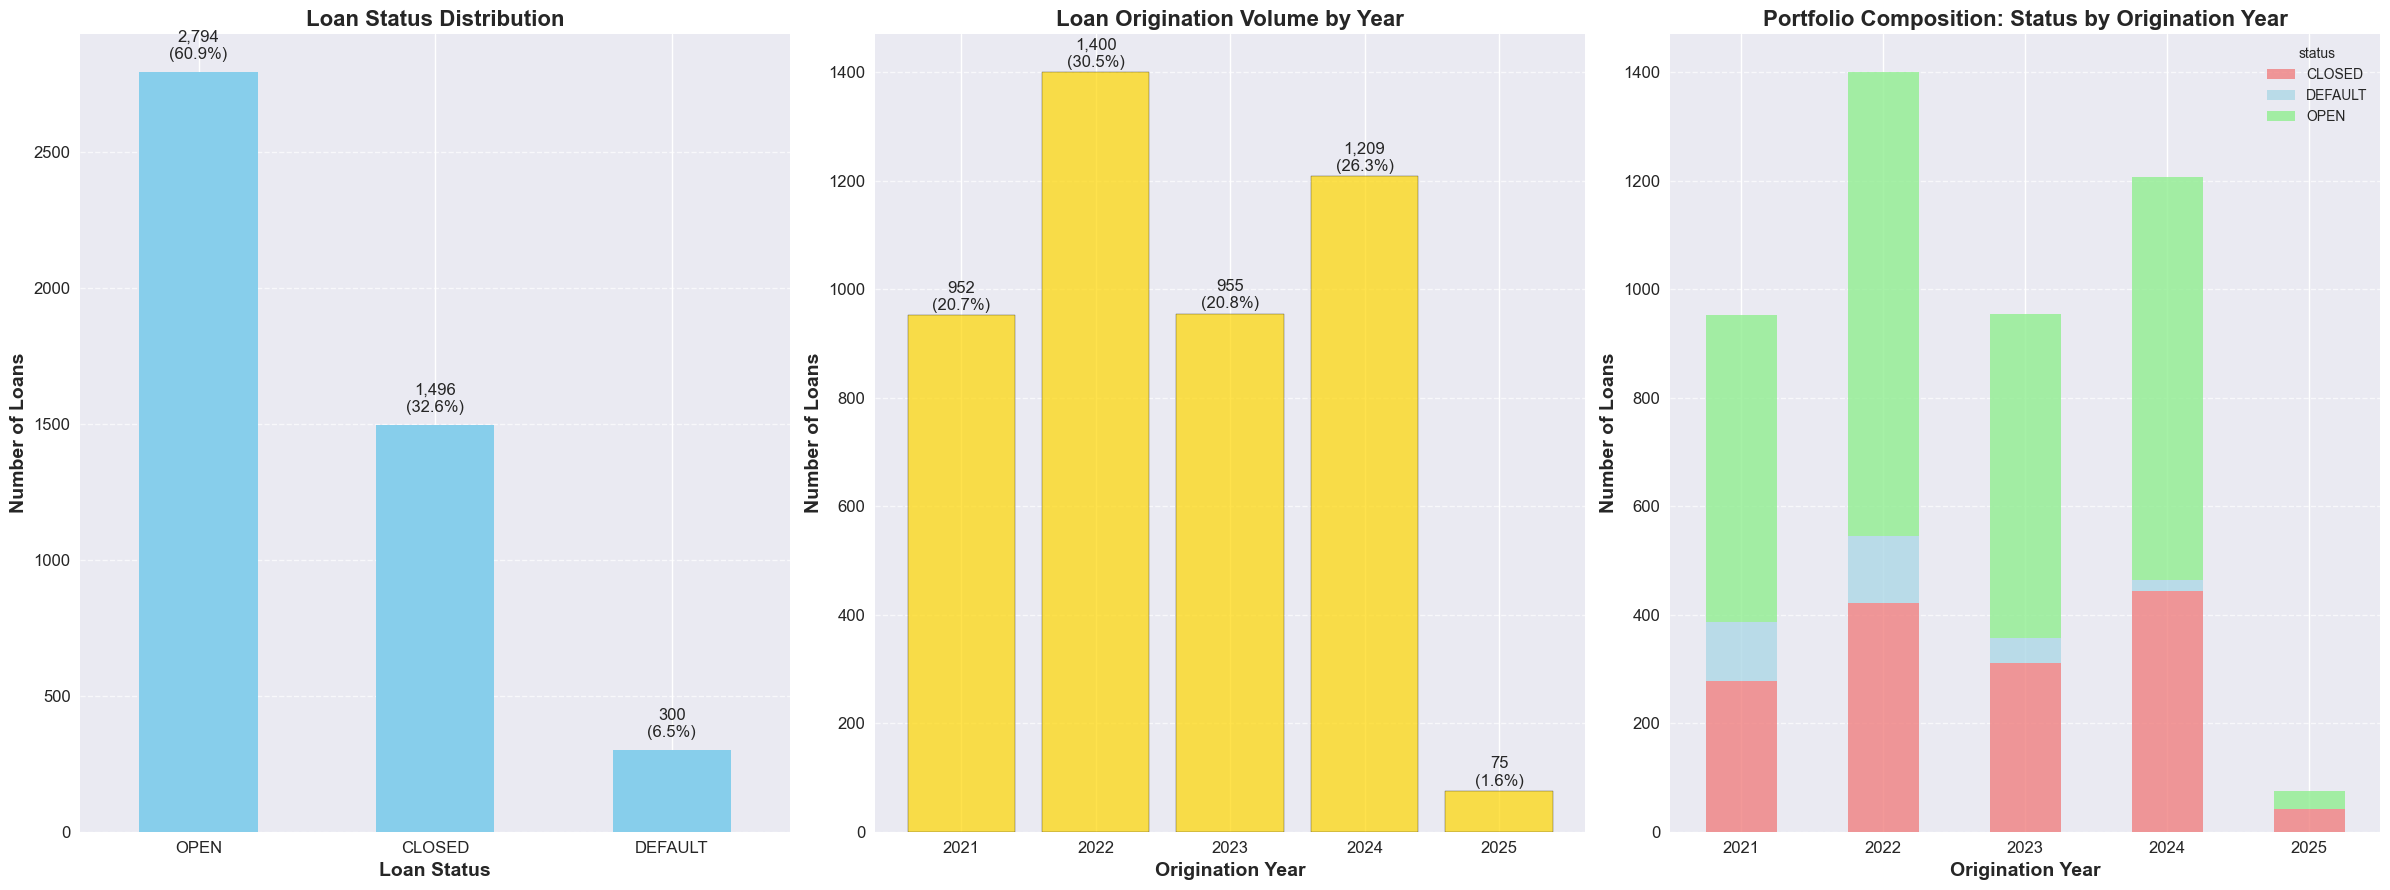

In [23]:
portfolio_summary_visual = portfolio_summary_visual(loan_data)

#### Portfolio Performance Overview
The 4,591-loan portfolio demonstrates strong performance characteristics with a 6.5% overall default rate and 32.6% closure rate, reflecting a mature portfolio with predictable risk patterns. With an average portfolio rate of 12.44%, original amount of $13,679, term of 49 months, and credit score of 698, the portfolio represents the characteristics of small- to mid-market usnecured personal loan portfolio profile. Origination volumes peaked in 2022 (1,400 loans) during favorable market conditions before declining in 2023-2025 as credit markets tightened. One notable event is a spike in loans originated in 2024. Given there was inherent uncertainty and additional risk in the market, it is likely underwriting was tightened in 2023 until rates began to stabilize, as they did in mid-2024. At which point, hopefully, appropriate pricing models were developed in an elevated rate environment. The portfolio composition shows natural seasoning effects, with earlier vintages (2021-2022) exhibiting higher closure rates as loans mature while maintaining consistent default patterns across all origination years, suggesting stable underwriting standards despite evolving market conditions. 

#### 1.2 Key Metrics Summary by Credit Score, Rate, and Opening Amount

In [24]:
loan_data['duration_months'] = (
        (loan_data['observation_date'] - loan_data['open_date']).dt.days / 30.44
    ).round(2)

In [25]:
print("\033[1mDEFAULT RATES BY ORIGINATION VINTAGE:\033[0m")
# Create the grouped data
vintage_defaults = loan_data.groupby('open_year').agg({
    'status': [
        'count',
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ],
    'duration_months': 'mean'
}).round(1)

# Flatten column names and rename
vintage_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_Pct', 'Avg_Duration_Months']

# Reset index to make open_year a column
vintage_defaults = vintage_defaults.reset_index()

print(vintage_defaults.to_string(index=False))

DEFAULT RATES BY ORIGINATION VINTAGE:
 open_year  Total_Loans  Defaults  Default_Rate_Pct  Avg_Duration_Months
      2021          952       108              11.3                 43.3
      2022         1400       125               8.9                 31.3
      2023          955        47               4.9                 18.9
      2024         1208        20               1.7                  7.3
      2025           75         0               0.0                  0.5


In [26]:
print("\033[1mDEFAULT RISK ANALYSIS BY KEY SEGMENTS:\033[0m")
# Credit Score Default Rates
print("1. Default Rates by Credit Score Segment:")
credit_defaults = loan_data.groupby('score_bucket').agg({
    'status': [
        'count',
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ]
}).round(1)
credit_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_%']
print(credit_defaults)

# Rate Bucket Default Rates  
print("\n2. Default Rates by Interest Rate Segment:")
rate_defaults = loan_data.groupby('rate_bucket').agg({
    'status': [
        'count', 
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ]
}).round(1)
rate_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_%']
print(rate_defaults)

# Rate Bucket Default Rates  
print("\n3. Default Rates by Loan Amount Segment:")
rate_defaults = loan_data.groupby('orig_amount_bucket').agg({
    'status': [
        'count', 
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ]
}).round(1)
rate_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_%']
print(rate_defaults)

# Risk Differentiation Summary
print(f"\n4. Risk Differentiation:")
highest_risk = credit_defaults['Default_Rate_%'].max()
lowest_risk = credit_defaults['Default_Rate_%'].min()
print(f"   • Credit Score Risk Spread: {highest_risk - lowest_risk:.1f} percentage points")
print(f"   • Highest Risk Segment: {highest_risk:.1f}% default rate")
print(f"   • Lowest Risk Segment: {lowest_risk:.1f}% default rate")

DEFAULT RISK ANALYSIS BY KEY SEGMENTS:
1. Default Rates by Credit Score Segment:
              Total_Loans  Defaults  Default_Rate_%
score_bucket                                       
Subprime              277        48            17.3
Near-Prime            346        54            15.6
Prime                2139       139             6.5
Super-Prime          1828        59             3.2

2. Default Rates by Interest Rate Segment:
             Total_Loans  Defaults  Default_Rate_%
rate_bucket                                       
Low                  983        42             4.3
Low-Med             2092       132             6.3
Medium              1079        73             6.8
Med-High             315        37            11.7
High                 115        14            12.2

3. Default Rates by Loan Amount Segment:
                    Total_Loans  Defaults  Default_Rate_%
orig_amount_bucket                                       
Very Low                    877        68       

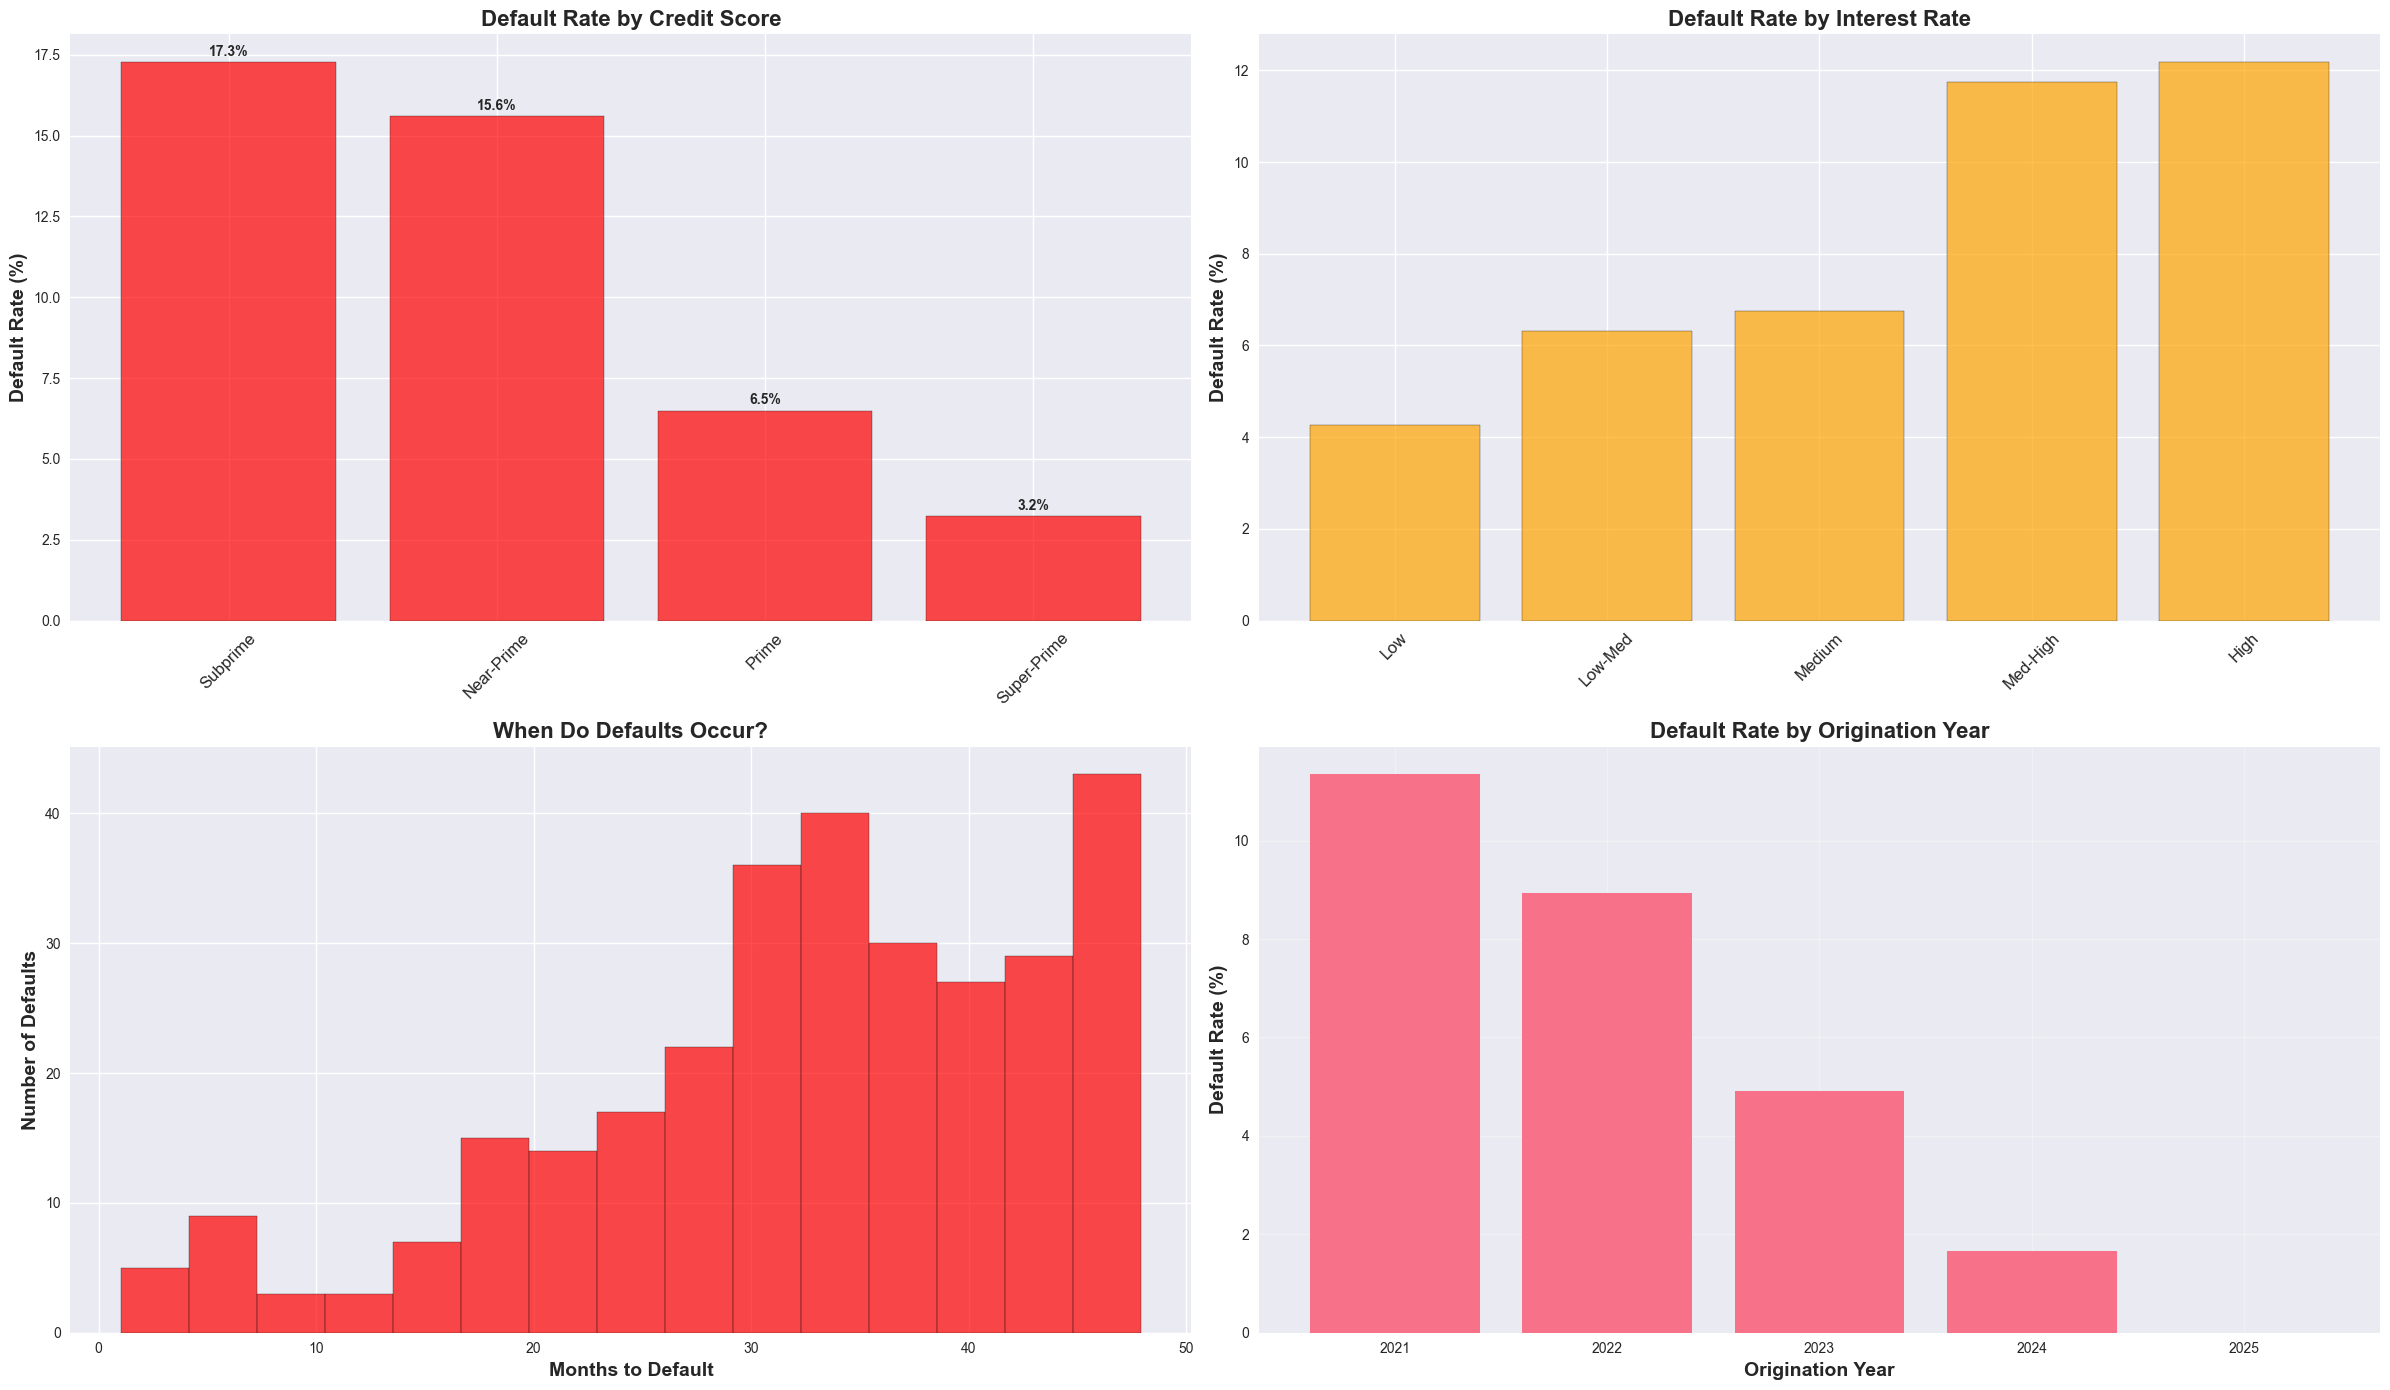

In [27]:
default_rate_analysis(loan_data)

#### Risk Segmentation Validation

The portfolio demonstrates clear risk differentiation across credit score risk segments. The credit score segmentation shows the strongest risk discrimination with a 14.1 percentage point spread between highest-risk (Subprime: 17.3%) and lowest-risk (Super-Prime: 3.2%) borrowers. Interest rate segmentation similarly reflects appropriate risk pricing, with high-rate borrowers exhibiting 12.2% default rates compared to 4.3% for low-rate segments. The Loan Amount segmentation shows little differentation and does not appear to have an impact on predicting the borrowers risk profile.  

Segmentation by vintage reveals the portfolio's natural maturation cycle, with older vintages (2021: 11.3% default rate) showing natural seasoning effects as loans reach their typical default periods, while newer originations demonstrate lower current default rates due to insufficient seasoning time. The 2022 vintage's 8.9% default rate at 31.3 months average duration may suggest peak default timing occurs in the 24-36 month range.

## 2.0 Survival Rate Analysis

This analysis employs two survival analysis techniques to model loan default behavior within an unsecured personal loan portfolio. The study utilizes binary event outcomes where 1 indicates loan default and 0 indicates open or closed loans. Two complementary survival modeling approaches are implemented to provide comprehensive risk assessment capabilities.

The first model is the Kaplan-Meier Fitter to determine the portfolio survival profitability at the life-of-loan evolution. The second model employed is the Nelson-Aalen estimator to calculate cumulative hazard functions.

This survival modeling framework directly supports key lending operations including loan pricing strategies, portfolio risk monitoring, and regulatory stress testing requirements. The Kaplan-Meier outputs enable risk-adjusted pricing decisions and portfolio segmentation strategies, while the Nelson-Aalen cumulative hazards inform loss provisioning and capital allocation planning. Together, these models provide actionable insights for optimizing portfolio performance while managing risk.


#### 2.1 Baseline Kaplan-Meier Survival Rate and Cumulative Hazard Analysis

In [28]:
print("\033[1mBASELINE SURVIVAL ANALYSIS - DATA PREPARATION:\033[0m")
survival_data = prepare_survival_data(loan_data, '01-31-2025')

BASELINE SURVIVAL ANALYSIS - DATA PREPARATION:
  Observation Date: 2025-01-31
  Total Loans: 4,591
  Default Events: 300 (6.5%)
  Censored Observations: 4,291 (93.5%)
  Average Duration: 24.4 months
  Duration Range: 0.0 to 48.0 months


#### 2.2 Fit and Visualize the Baseline Model

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Initialize Kaplan-Meier Fitter
    kmf = KaplanMeierFitter()
        
    # Fit the survival curve
    kmf.fit(survival_data['duration_months'], 
                survival_data['event'],
                label='Portfolio Baseline Survival Rate')

    # Initialize Nelson Aalen Fitter
    naf = NelsonAalenFitter()

    # Fit hazard curve
    naf.fit(survival_data['duration_months'], 
            survival_data['event'],
            label= 'Portfolio Baseline Hazard Rate')

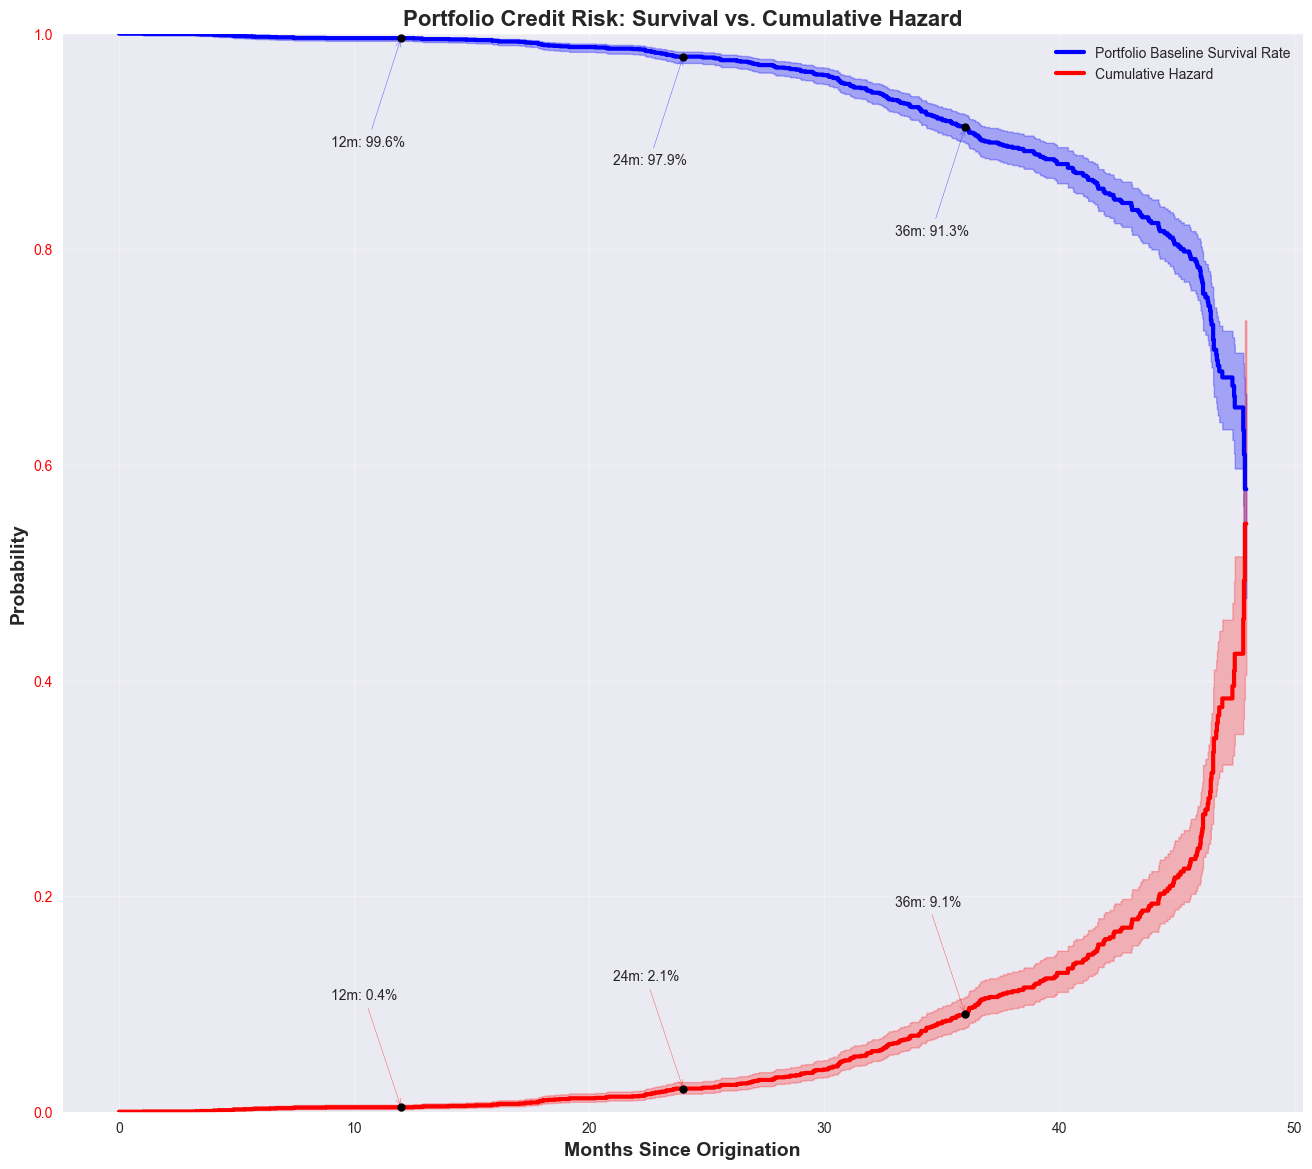

In [30]:
survival_hazard_curve_visual = survival_hazard_curve_visual(survival_data, kmf, naf)

In [31]:
print("\033[1mPORTFOLIO RISK METRICS:\033[0m")
baseline_portfolio_summary(survival_data)

PORTFOLIO RISK METRICS:
  Overall Default Rate: 6.5%
  Average Observation Period: 24.4 months
  Estimated Annualized Default Rate: 3.2%


In [32]:
print("\033[1mBASELINE SURVIVAL STATISTICS:\033[0m")
generate_survival_statistics(kmf, naf)

# For loans that DO default, what's the median time?
defaulted_loans = survival_data[survival_data['event'] == 1]
median_time_to_default = defaulted_loans['duration_months'].median()
print(f"\n  Median time to default (for loans that default): {median_time_to_default:.1f} months")
mean_time_to_default = defaulted_loans['duration_months'].mean()
print(f"\n  Average time to default (for loans that default): {mean_time_to_default:.1f} months")

BASELINE SURVIVAL STATISTICS:
   6 months: 99.7% survival | 0.3% default rate | Cumulative Hazard: 0.3%
  12 months: 99.6% survival | 0.4% default rate | Cumulative Hazard: 0.4%
  18 months: 99.0% survival | 1.0% default rate | Cumulative Hazard: 1.0%
  24 months: 97.9% survival | 2.1% default rate | Cumulative Hazard: 2.1%
  30 months: 96.2% survival | 3.8% default rate | Cumulative Hazard: 3.9%
  36 months: 91.3% survival | 8.7% default rate | Cumulative Hazard: 9.1%

  Median time to default (for loans that default): 33.6 months

  Average time to default (for loans that default): 32.4 months


The survival analysis reveals distinct risk phases within the loan portfolio lifecycle, most notably at 24 and 36 months. During the initial 24-month period, the portfolio demonstrates strong performance with minimal default activity (cumulative hazard of only 2.1%), reflecting effective underwriting standards and borrower selection criteria in the short term.

The analysis identifies 24-30 months as a critical risk transition period, which also coincides with the portfolio's average loan duration of 24.4 months. This appears to be a critical inflection point and represents a shift in borrower behavior patterns, where loans transition from the stable early-life phase into a higher-risk maturity period. The survival probability decline from 97.9% at 24 months to 91.3% at 36 months represents a clear acceleration of credit stress as loans approach their natural conclusion.

Most notably, the risk profile steepens dramatically beyond 36 months for both the survival probability and cumulative hazard curves. This pattern suggests that loans extending beyond three years face significantly elevated default risk, indicating potential borrower financial distress or changing economic conditions affecting repayment capacity.


#### 2.3 Fit and Visualize Models with Risk Segmentation

In [33]:
print("\033[1mSEGMENTED CREDIT ANALYSIS:\033[0m")
segmented_table = risk_segment_credit_analysis(survival_data)
print(segmented_table)

SEGMENTED CREDIT ANALYSIS:
  Risk Segment  Total Loans  Default Loans  Default Rate (%)  Average Duration
0     Subprime          278             48              17.3             27.63
1   Near-Prime          346             54              15.6             24.19
2        Prime         2139            139               6.5             24.14
3  Super-Prime         1828             59               3.2             24.27


In [34]:
segments = ['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
segment_col = 'score_bucket'
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'] 

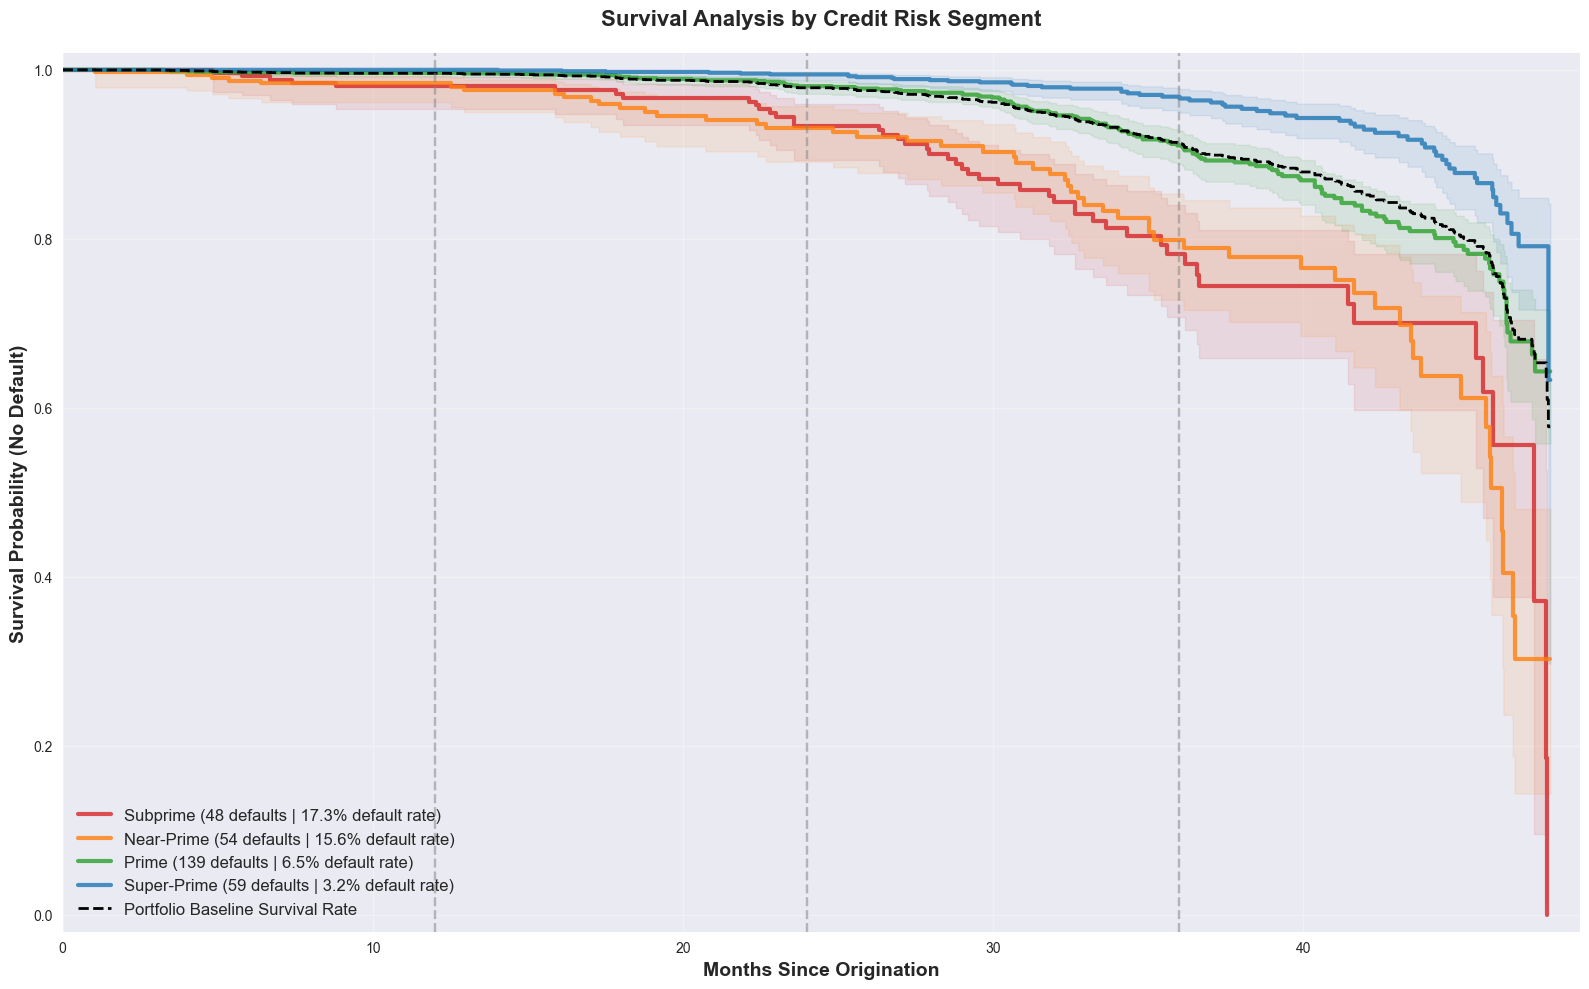

In [35]:
segmented_survival_analysis = create_segmented_survival_analysis(survival_data, segments, segment_col, colors, kmf)

In [36]:
print("\033[1mCREDIT RISK HEATMAP ANALYSIS:\033[0m")

CREDIT RISK HEATMAP ANALYSIS:


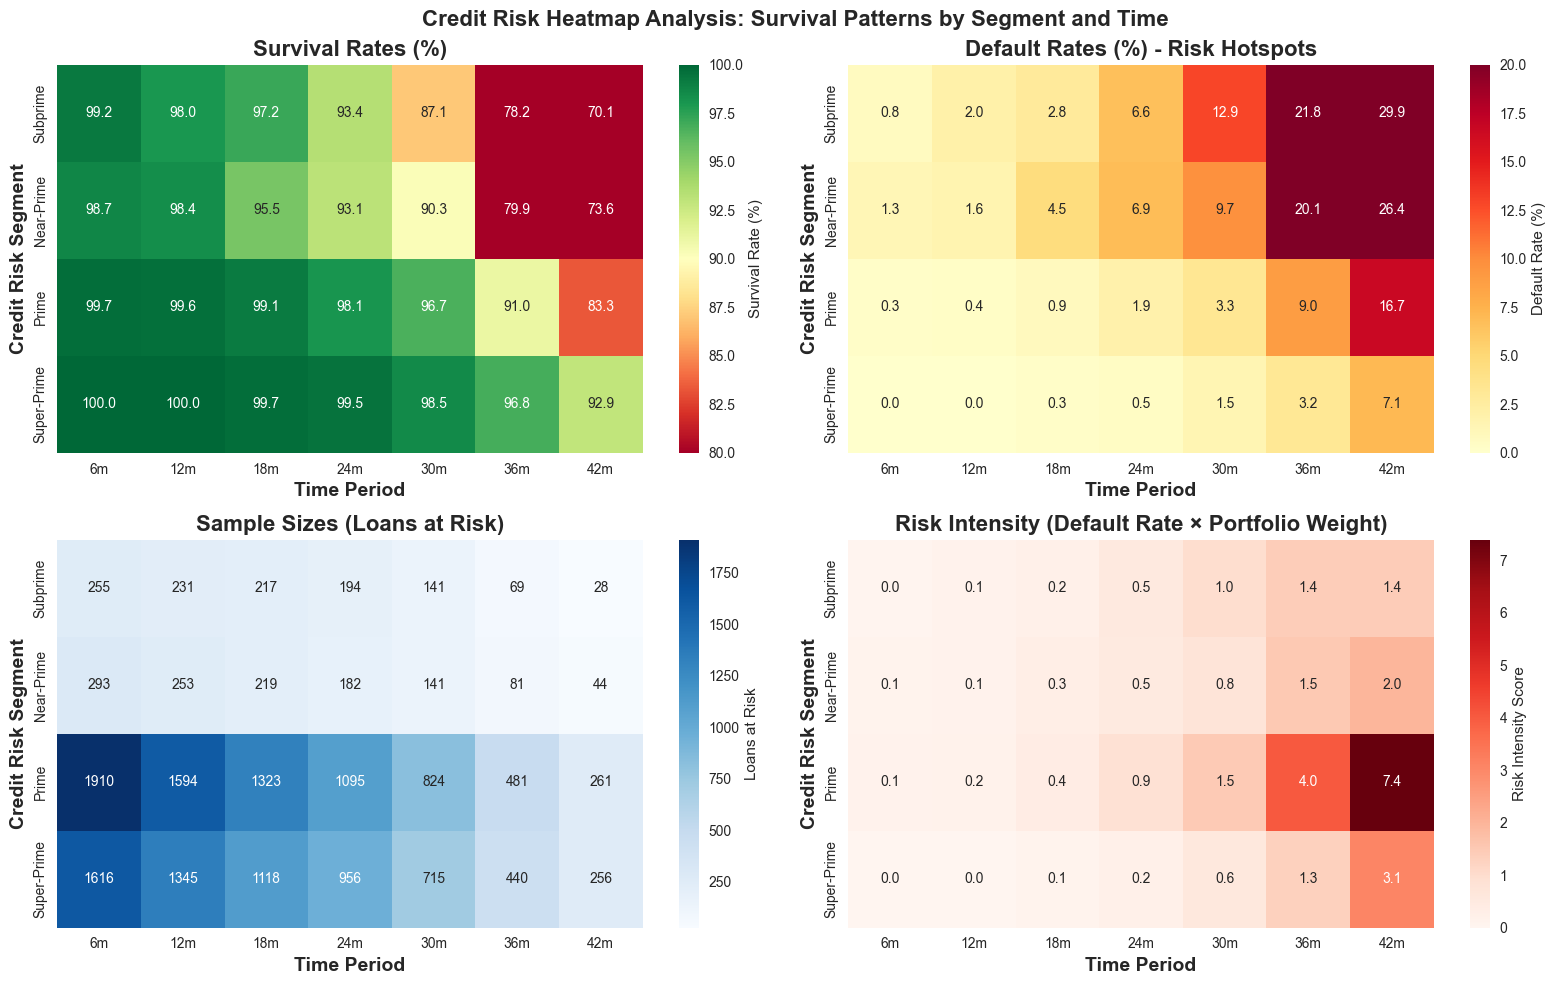

In [37]:
survival_df, default_df, sample_df = create_survival_heatmap_data(survival_data, segments, segment_col)
survival_heatmaps = plot_survival_heatmaps(survival_df, default_df, sample_df, segment_col)

This analysis reveals that traditional credit score segmentation may oversimplify risk patterns in the 24+ month timeframe. While Super-Prime borrowers maintain consistently superior performance, the convergence of Near-Prime and Subprime survival curves suggests that after the initial seasoning period, factors beyond credit scores (employment stability, life events) may become more predictive of default risk. The significant contribution of Prime borrowers to later-stage defaults (As indicated in the Risk Intensity measurement) highlights the importance of monitoring portfolio concentration risk, not just segment-level default rates. Prime has lower default rates (6.5%) but much larger exposure (2,139 loans). At 42 months, their sheer volume makes them a major contributor to absolute losses at level that outpaces Near-Prime and Subprime loans.

#### 2.5 Fit and Visualize Model with Interest Rate Period Segmentation

In [38]:
segments = survival_data['rate_status'].unique()
segment_col = 'rate_status'
colors = ['tomato', 'blue']

In [39]:
survival_data['score_bucket'].unique()

['Prime', 'Super-Prime', 'Subprime', 'Near-Prime']
Categories (4, object): ['Subprime' < 'Near-Prime' < 'Prime' < 'Super-Prime']

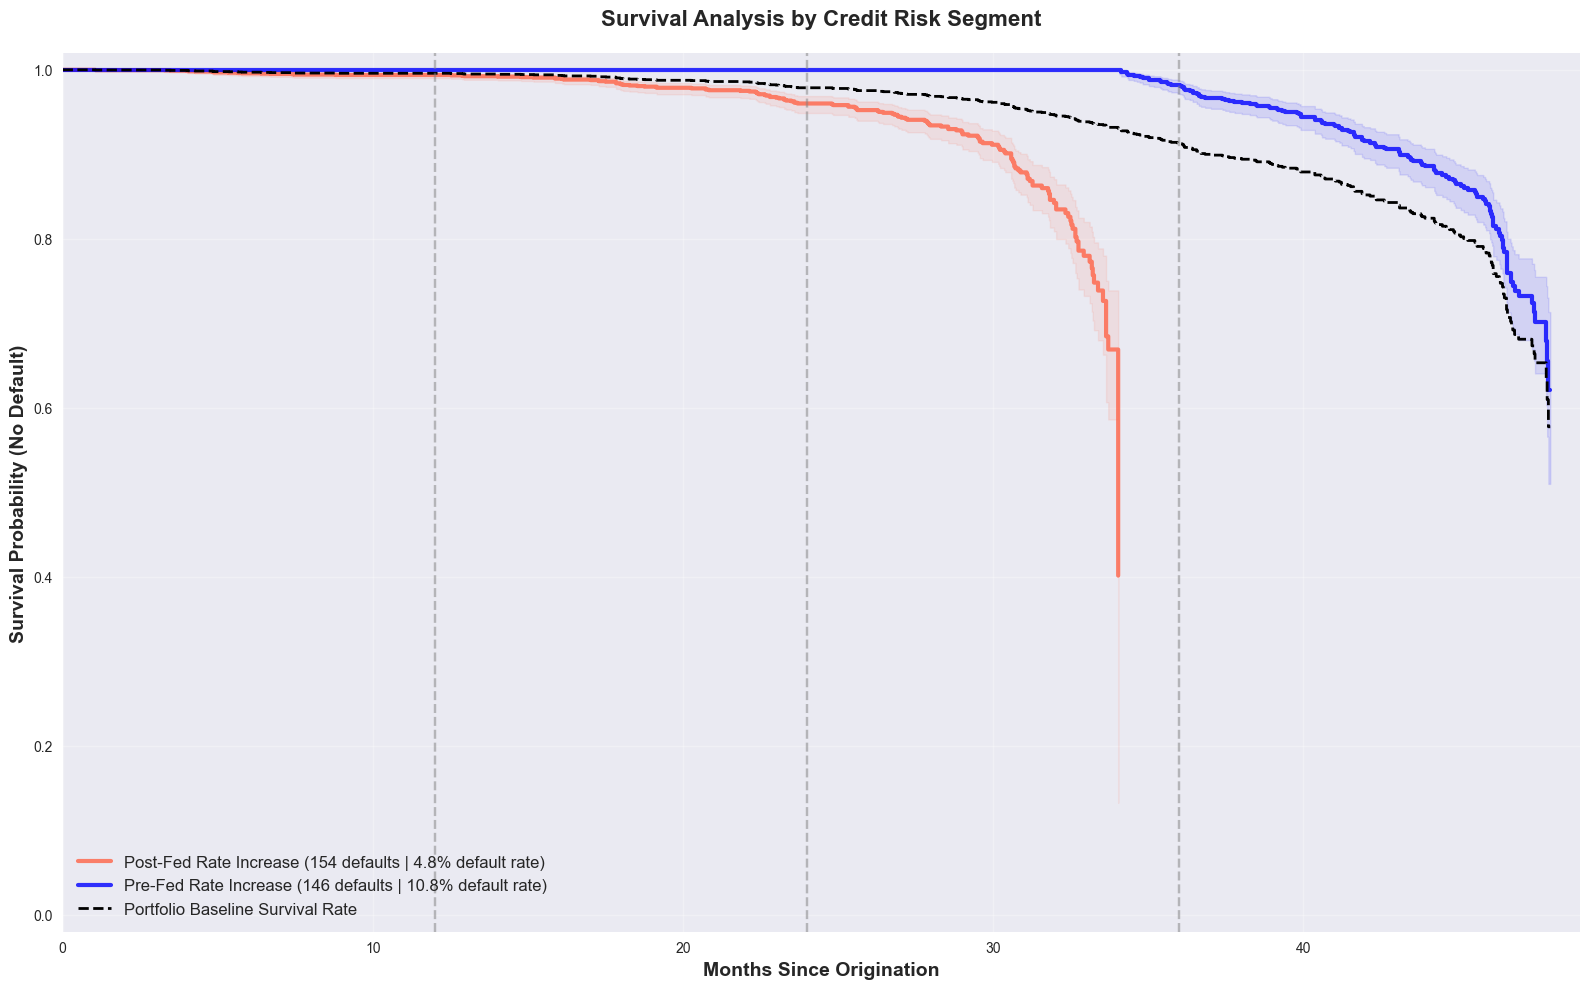

In [40]:
segmented_survival_analysis = create_segmented_survival_analysis(survival_data, segments, segment_col, colors, kmf)

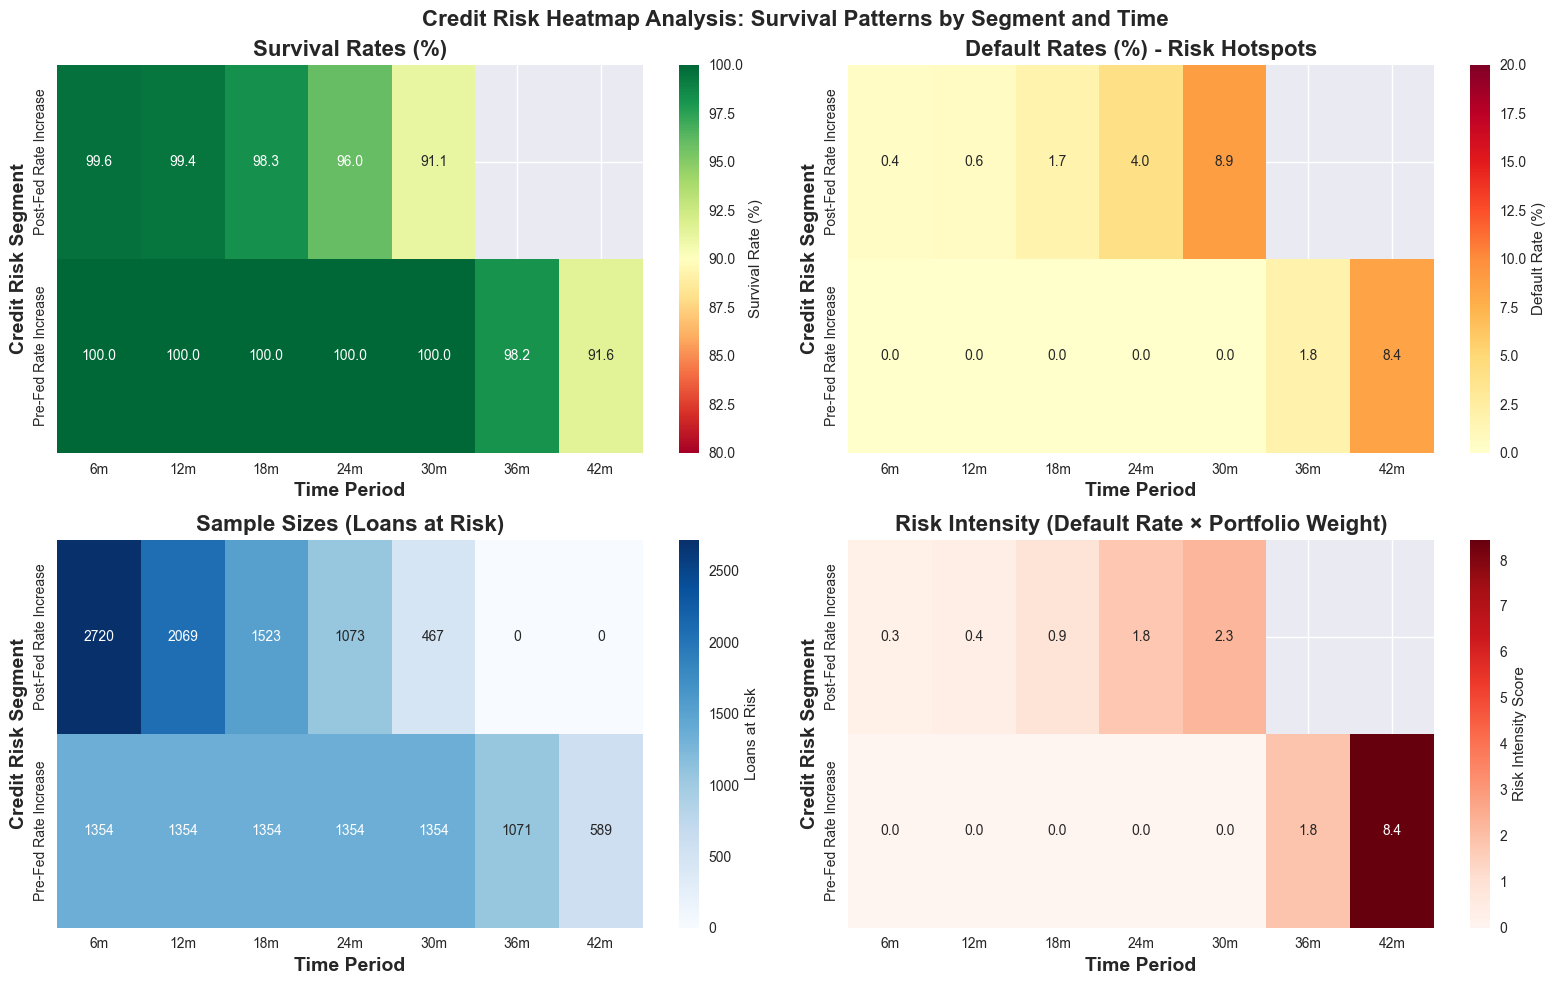

In [41]:
survival_df, default_df, sample_df = create_survival_heatmap_data(survival_data, segments, segment_col)
survival_heatmaps = plot_survival_heatmaps(survival_df, default_df, sample_df, segment_col)

The steeper survival curve decline for post-Fed rate increase originations signals elevated immediate default risk, suggesting borrowers are experiencing financial stress earlier in the loan lifecycle. While total observed defaults remain lower due to insufficient seasoning (4.8% vs 10.8%), the accelerated default timing pattern indicates these vintages may ultimately perform worse than pre-rate increase loans once fully matured. As a result, those segment of the loan pool may see an earlier inflection point somewhere between 18 to 24 months. 

#### 2.6 Fit and Visualize with Risk and Interest Rate Period Segmentation

In [42]:
survival_data['risk_rate_segment'] = survival_data.apply(lambda row: f"{row['score_bucket']}, {row['rate_status']}", axis=1)

In [43]:
segments = ['Super-Prime, Pre-Fed Rate Increase', 'Prime, Pre-Fed Rate Increase', 'Near-Prime, Pre-Fed Rate Increase','Subprime, Pre-Fed Rate Increase',
            'Super-Prime, Post-Fed Rate Increase', 'Prime, Post-Fed Rate Increase', 'Near-Prime, Post-Fed Rate Increase', 'Subprime, Post-Fed Rate Increase']
segment_col = 'risk_rate_segment'
colors = [ "#05409e", "#2470b9","#4599d1","#68bee8", "#d61f1f", "#e04441", "#e76447", "#e58638"]

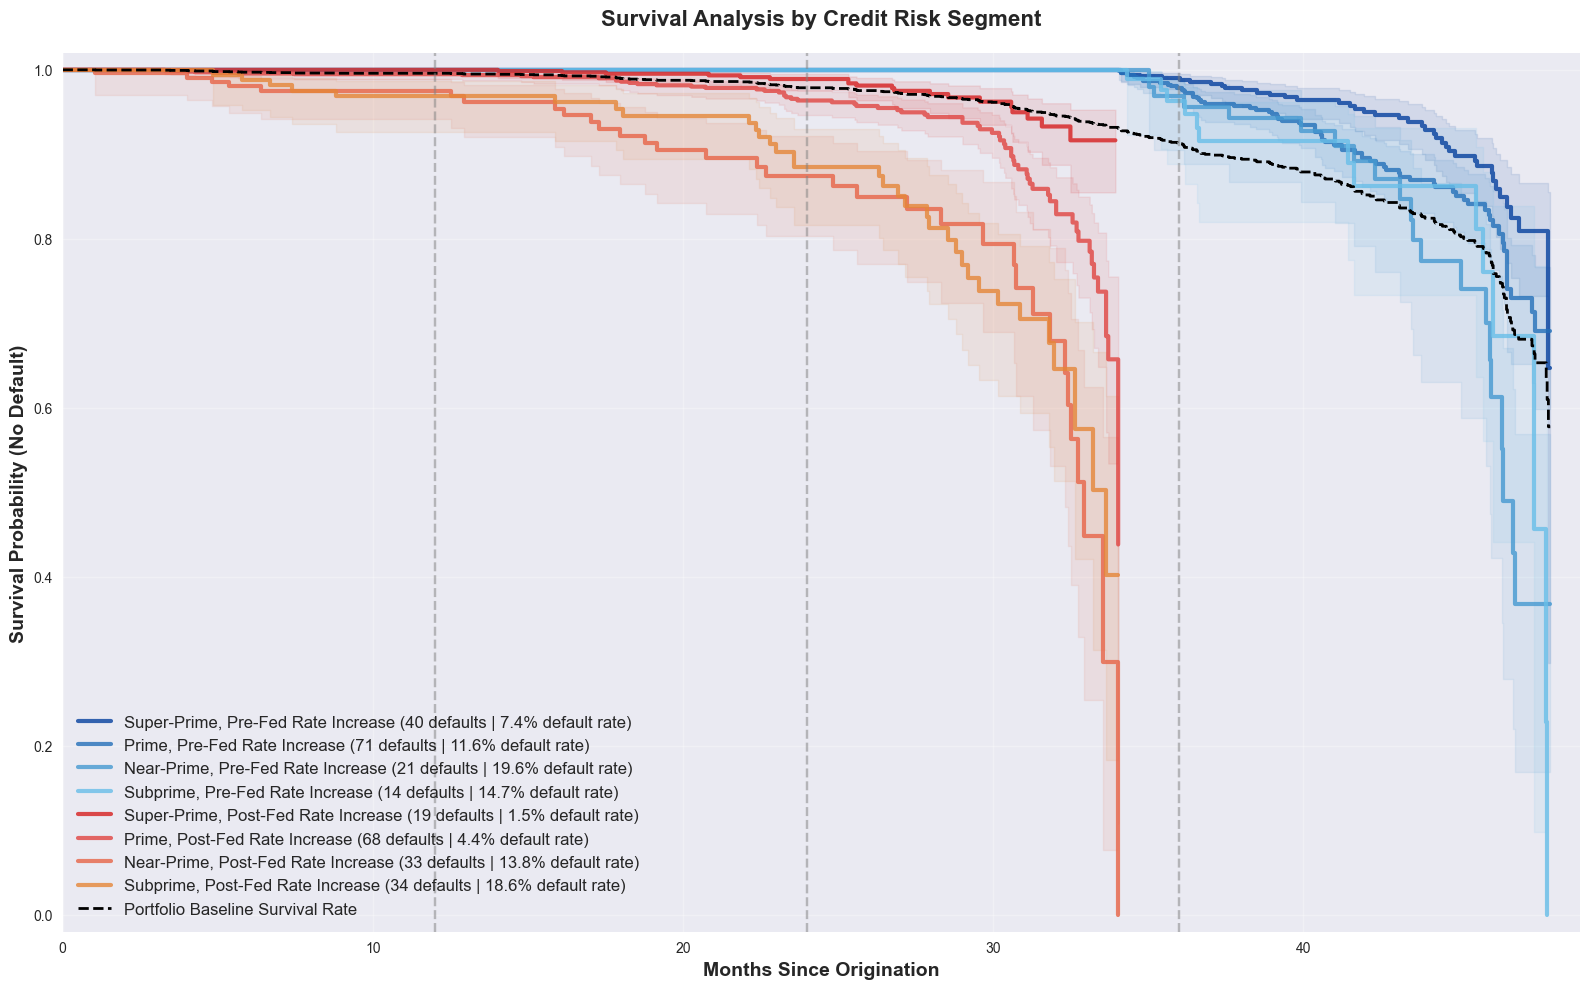

In [44]:
segmented_survival_analysis = create_segmented_survival_analysis(survival_data, segments, segment_col, colors, kmf)

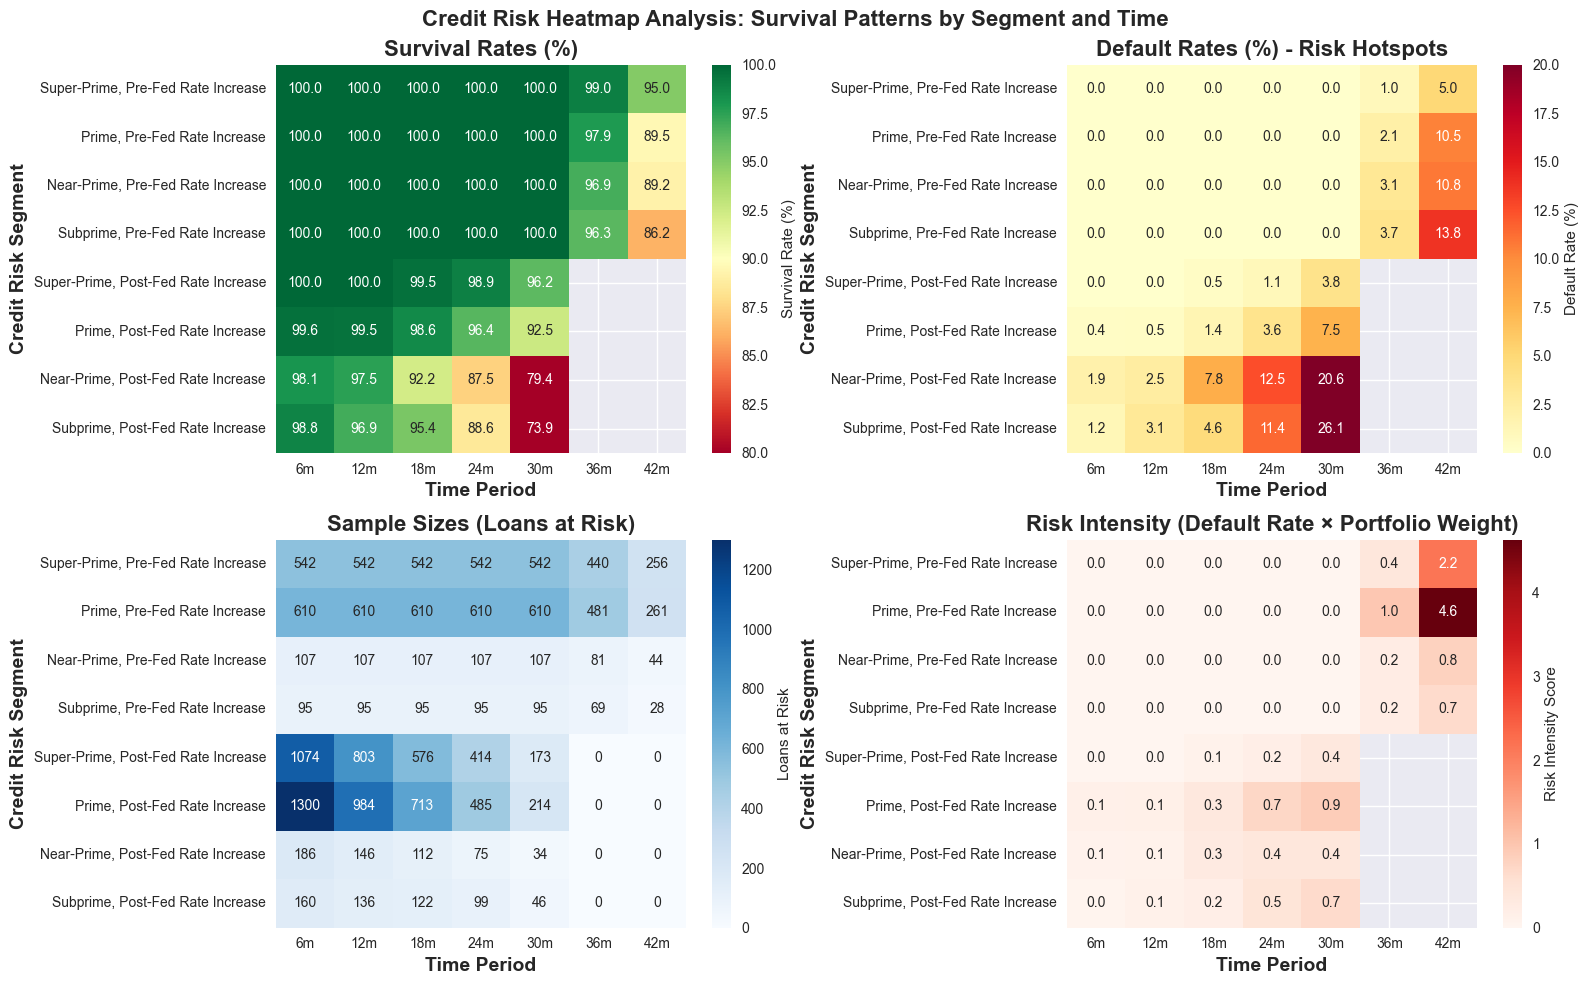

In [45]:
survival_df, default_df, sample_df = create_survival_heatmap_data(survival_data, segments, segment_col)
survival_heatmaps = plot_survival_heatmaps(survival_df, default_df, sample_df, segment_col)

The combined credit tier and rate environment analysis shows a clear and distinct shift in portfolio risk dynamics, with the elevated rate period (April 2022-2025) showing dramatically accelerated default timing. While pre-rate increase originations had survival rates above baseline through 42+ months regardless of credit tier, post-rate increase loans show steeper decline curves and earlier default materialization (18-24 months vs. 30+ months), which is likely an indicator that payment burden stress is overwhelming current borrowers. This likely suggests current underwriting standards are insufficient and require recalibration for elevated rate environments. For example, higher minimum credit score thresholds and a shift toward shorter-term products (24-36 months) that function as bridge financing rather than long-term consumer loans. 

## 3.0 Risk Management Applications

#### **Credit Risk Management Strategy: Rate Environment Adaptation**

Survival analysis reveals that elevated interest rate environments fundamentally alter borrower stress patterns, requiring immediate portfolio strategy adjustments to maintain risk-adjusted returns while protecting against accelerated default timing. This strategy would take a three-pillar approach: 1) Portfolio Composition Management, 2) Risk-Adjusted Recalibration of Underwriting, and 3) Early Warning Detection System.

##### **Three-Pillar Implementation Framework:**

**1. Portfolio Composition Management:**

OBJECTIVE: Reduce and manage concentration risk during elevated rate cycles

In order to reduce and manage concentration risk, rate environment triggers should be established as standard policy. This would require adjusting exposure limits for different fed funds rates tiers. For example, in a normal rate environment the maximum Subprime/Near-Prime combined concentration should be limited to 30%. At Fed Funds > 2%, reduce exposure to 25% exposure; at  > 4%, reduce to 20% exposure. In addition, there would be value in vintage concentration limits, such as ensuring no single origination year >25% of total portfolio.

Portfolio Concentration of this sort should be managed, monitored and reported at a monthly committee meeting, such as a Credit Risk Committee (CRC). This could a standing presentation and report for committee packets. However, there would also be value in monthly dashboard monitoring to track actual concentration against target composition to identify variances. 

**2. Risk-Adjusted Underwriting Standards**

OBJECTIVE: Align loan terms and amounts with borrower payment capacity

Implement tiered lending limits that reduce payment burden on borrower capacity. Subprime borrowers (<600 credit score) will be limited to 24-month terms with maximum loan amounts of $10,000, maintaining payment-to-income ratios below 10% to ensure sustainability. Near-Prime borrowers (600-649) receive 30-month maximum terms with $15,000 loan caps and 12% payment-to-income limits. Prime borrowers (650-729) qualify for 36-month ter**ms up to $25,000 with 15% payment ratios, while Super-Prime borrowers (730+) access the full product suite up to $35,000 and 48-month terms during normal rate environments. During elevated rate periods (Fed Funds >4%), minimum credit score requirements increase by 20-40 points per tier, and 48-month terms are suspended entirely. All applications must pass stress-testing at 200-300 basis points above the note rate to ensure payment viability under potential rate increases.

**3. Early Warning Detection System**

OBJECTIVE: Proactive intervention before inflection point of 30-month default window

Establish 18-24 month monitoring triggers such as: 1) Identify payment pattern deterioration (late payments, partial payments, negative deposit balances) and 2) Credit score declines of >30 points from origination. Proactively reach out to borrowers to identify root cause of financial stress.

Early intervention strategies could include refinancing of Auto or secured loans to consolidate payments, payment modification (Temporary rate reduction or term extension), or even early settlement to minimize loss. 

##### **GOAL: Risk Adjusted Value Creation**

Rather than simply reducing lending activity during challenging market conditions, this strategy enables continued growth through appropriate risk pricing and proactive risk management. The tiered approach ensures that each borrower segment receives terms aligned with their demonstrated payment capacity while providing early intervention opportunities to protect portfolio performance before defaults materialize.


In [46]:
survival_data.columns

Index(['loan_id', 'open_date', 'credit_score', '6_month_credit_score', 'term',
       'rate', 'orig_amount', 'status', 'rate_bucket', 'score_bucket',
       'orig_amount_bucket', 'open_year', 'open_month', 'open_month_str',
       'maturity_date', '6_month_score_change', 'rate_status', 'event_target',
       'observation_date', 'duration_months', 'event', 'risk_rate_segment'],
      dtype='object')

In [47]:
survival_data['score_bucket'].unique()

['Prime', 'Super-Prime', 'Subprime', 'Near-Prime']
Categories (4, object): ['Subprime' < 'Near-Prime' < 'Prime' < 'Super-Prime']

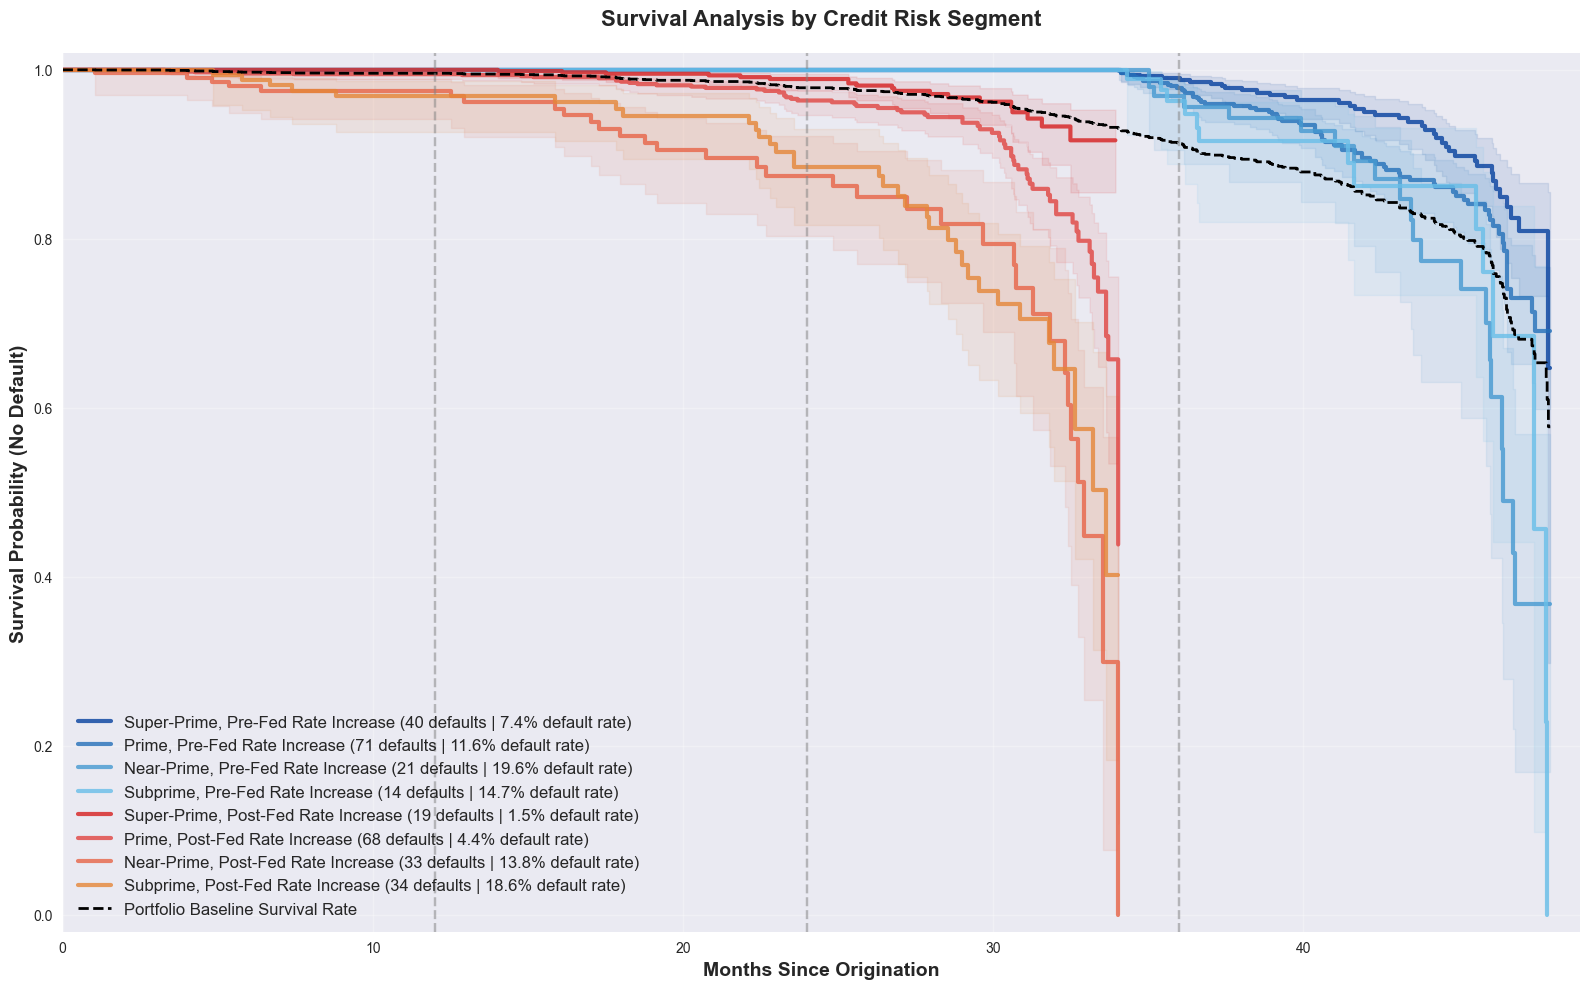

In [48]:
def create_segmented_survival_analysis(survival_data, segments, segment_col, colors, kmf_baseline):
    """
    Create survival analysis by credit score segments
    Focus on clean business insights
    """
    
    # Get unique segments in risk order (worst to best)
    #segments = ['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    
    # Colors for business presentation (red to green, worst to best risk)
    #colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']  # Red, Orange, Green, Blue
    
    # Storage for results
    segment_results = {}
    survival_summary = []
    
    # Create the main survival plot
    plt.figure(figsize=(16, 10))
    
    for i, segment in enumerate(segments):
        # Filter data for this segment
        segment_data = survival_data[survival_data[segment_col] == segment]

        # Calculate basic metrics
        total_loans = len(segment_data)
        defaults = segment_data['event'].sum()
        default_rate = (defaults / total_loans) * 100
        
        # Fit Kaplan-Meier for this segment
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=segment_data['duration_months'],
            event_observed=segment_data['event'],
            label=f'{segment} ({defaults} defaults | {round(default_rate, 1)}% default rate)'
        )
        
        # Plot survival curve
        kmf.plot_survival_function(
            color=colors[i], 
            linewidth=3,
            alpha=0.8,
            ci_alpha=0.1  # Light confidence interval
        )
        
        # Calculate key business metrics
        key_times = [6, 12, 18, 24, 30, 36]
        segment_metrics = {'segment': segment, 'total_loans': total_loans, 'defaults': defaults, 'default_rate': default_rate}
        
        for months in key_times:
            try:
                if months <= segment_data['duration_months'].max():
                    survival_prob = kmf.survival_function_at_times(months).values[0]
                    segment_metrics[f'survival_{months}m'] = survival_prob
                else:
                    segment_metrics[f'survival_{months}m'] = None
            except:
                segment_metrics[f'survival_{months}m'] = None
        
        survival_summary.append(segment_metrics)
        segment_results[segment] = {
            'kmf': kmf,
            'data': segment_data,
            'metrics': segment_metrics
        }
    
    # Format the plot
    kmf_baseline.plot_survival_function(ci_alpha = 0.0, color='black', linewidth=2, linestyle = '--')
    plt.title('Survival Analysis by Credit Risk Segment', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Months Since Origination', fontsize=14, fontweight='bold')
    plt.ylabel('Survival Probability (No Default)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left', fontsize=12, framealpha=0.9)
    
    # Add key milestone annotations
    plt.axvline(x=12, color='gray', linestyle='--', alpha=0.5, label='12 Month Mark')
    plt.axvline(x=24, color='gray', linestyle='--', alpha=0.5, label='24 Month Mark')
    plt.axvline(x=36, color='gray', linestyle='--', alpha=0.5, label='36 Month Mark')
    
    # Set axis limits
    plt.xlim(0, max(survival_data['duration_months']) * 1.02)
    plt.ylim(-.02, 1.02)  # Focus on the range where action happens
    
    plt.tight_layout()
    plt.show()
    
    return segment_results, survival_summary

survival_data['risk_rate_segment'] = survival_data.apply(lambda row: f"{row['score_bucket']}, {row['rate_status']}", axis=1)
segments = ['Super-Prime, Pre-Fed Rate Increase', 'Prime, Pre-Fed Rate Increase', 'Near-Prime, Pre-Fed Rate Increase','Subprime, Pre-Fed Rate Increase',
            'Super-Prime, Post-Fed Rate Increase', 'Prime, Post-Fed Rate Increase', 'Near-Prime, Post-Fed Rate Increase', 'Subprime, Post-Fed Rate Increase']
segment_col = 'risk_rate_segment'
colors = [ "#05409e", "#2470b9","#4599d1","#68bee8", "#d61f1f", "#e04441", "#e76447", "#e58638"]
segmented_survival_analysis = create_segmented_survival_analysis(survival_data, segments, segment_col, colors, kmf)


In [49]:

def kmf_baseline(survival_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Initialize Kaplan-Meier Fitter
        kmf = KaplanMeierFitter()
            
        # Fit the survival curve
        kmf.fit(survival_data['duration_months'], 
                    survival_data['event'],
                    label='Portfolio Baseline Survival Rate')
    return kmf

In [50]:
rate_period = ['Post-Fed Rate Increase', 'Pre-Fed Rate Increase']
score_tier = ['Prime', 'Super-Prime']
baseline = False

colors = [
    {"label": 'Super-Prime, Pre-Fed Rate Increase', "color": "#05409e"},
    {"label": 'Prime, Pre-Fed Rate Increase', "color": "#2470b9"},
    {"label": 'Near-Prime, Pre-Fed Rate Increase', "color": "#4599d1"},
    {"label": 'Subprime, Pre-Fed Rate Increase', "color": "#68bee8"},
    {"label": 'Super-Prime, Post-Fed Rate Increase', "color": "#d61f1f"},
    {"label": 'Prime, Post-Fed Rate Increase', "color": "#e04441"},
    {"label": 'Near-Prime, Post-Fed Rate Increase', "color": "#e76447"},
    {"label": 'Subprime, Post-Fed Rate Increase', "color": "#e58638"},
    {"label": 'Pre-Fed Rate Increase', "color": "#05409e"},
    {"label": 'Post-Fed Rate Increase', "color": "#d61f1f"},
    {"label": 'Super-Prime', "color": "#05409e"},
    {"label": 'Prime', "color": "#4599d1"},
    {"label": 'Near-Prime', "color": "#e04441"},
    {"label": 'Subprime', "color": "#e58638"}
]

In [ ]:
def create_combined_survival_analysis(survival_data, rate_period, score_tier, colors, baseline=True):
    #create table segments for dataframe
    risk_segment_col = []
    default_rate_col = []
    median_time_to_default_col = []
    survival_12mo_col = []
    survival_24mo_col = []
    survival_36mo_col = []
    default_size_col = []
    sample_size_col = []


    fig = plt.figure(figsize=(16, 12))

    # establish baseline kmf
    def kmf_baseline(survival_data):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Initialize Kaplan-Meier Fitter
            kmf = KaplanMeierFitter()
                    
            # Fit the survival curve
            kmf.fit(survival_data['duration_months'], 
                            survival_data['event'],
                            label='Portfolio Baseline Survival Rate')
        return kmf

    # Fit the baseline model
    kmf = kmf_baseline(survival_data)
    if baseline == True:
        baseline = kmf.plot_survival_function(ci_alpha = 0.0, color='black', linewidth=2, linestyle = '--', label='Baseline Survival Rate')
    if baseline == False:
        baseline = plt.subplot(1,1,1) # Create empty subplot for custom plotting    

    def plot_objects(column, kmf):
        for i, rate in enumerate(column):
                segment = f"{rate}"
                # Filter data for this segment
                segment_data = survival_data[survival_data['rate_status'] == segment]
                for i in colors:
                        if i['label'] == segment:
                            color = i['color']

                # Calculate basic metrics
                total_loans = len(segment_data)
                defaults = segment_data['event'].sum()
                default_rate = (defaults / total_loans) * 100

                risk_segment_col.append(segment)
                default_rate_col.append(round(default_rate, 1))
                median_time_to_default_col.append(segment_data['duration_months'].median())
                default_size_col.append(defaults)
                sample_size_col.append(total_loans)

                # Fit Kaplan-Meier for this segment
                kmf = KaplanMeierFitter()
                kmf.fit(
                    durations=segment_data['duration_months'],
                    event_observed=segment_data['event'],
                    label=f'{segment}'# ({defaults} defaults | {round(default_rate, 1)}% default rate)'
                    )      
                
                survival_prob_12 = kmf.survival_function_at_times(12).values[0]
                survival_12mo_col.append(round(survival_prob_12*100, 1))

                survival_prob_24 = kmf.survival_function_at_times(24).values[0]
                survival_24mo_col.append(round(survival_prob_24*100, 1))

                survival_prob_36 = kmf.survival_function_at_times(36).values[0]
                survival_36mo_col.append(round(survival_prob_36*100, 1))

                # Plot survival curve
                plot_objects = kmf.plot_survival_function(
                        ax=baseline,
                        color=color, 
                        linewidth=3,
                        alpha=0.8,
                        ci_alpha=0.1  # Light confidence interval
                        )
                
            

    if len(score_tier) == 0:
         plot_objects(rate_period, kmf)
   
    elif len(rate_period) == 0:
        plot_objects(score_tier, kmf)
            
    else:
        for i, rate in enumerate(rate_period):
            for j, score in enumerate(score_tier):
                segment = f"{score}, {rate}"
                # Filter data for this segment
                segment_data = survival_data[survival_data['risk_rate_segment'] == segment]
                    
                for i in colors:
                    if i['label'] == segment:
                        color = i['color']

                # Calculate basic metrics
                total_loans = len(segment_data)
                defaults = segment_data['event'].sum()
                default_rate = (defaults / total_loans) * 100

                risk_segment_col.append(segment)
                default_rate_col.append(round(default_rate, 1))
                median_time_to_default_col.append(segment_data['duration_months'].median())
                default_size_col.append(defaults)
                sample_size_col.append(total_loans)
                
                # Fit Kaplan-Meier for this segment
                kmf = KaplanMeierFitter()
                kmf.fit(
                    durations=segment_data['duration_months'],
                    event_observed=segment_data['event'],
                    label=f'{segment} ({defaults} defaults | {round(default_rate, 1)}% default rate)'
                    )
                
                survival_prob_12 = kmf.survival_function_at_times(12).values[0]
                survival_12mo_col.append(round(survival_prob_12*100, 1))

                survival_prob_24 = kmf.survival_function_at_times(24).values[0]
                survival_24mo_col.append(round(survival_prob_24*100, 1))

                survival_prob_36 = kmf.survival_function_at_times(36).values[0]
                survival_36mo_col.append(round(survival_prob_36*100, 1))
                
                # Plot survival curve
                plot_objects = kmf.plot_survival_function(
                    ax=baseline,
                    color=color, 
                    linewidth=3,
                    alpha=0.8,
                    ci_alpha=0.1  # Light confidence interval
                    )



            
    # Format the plot
    ax = baseline

    # Get the Figure object from the AxesSubplot
    fig = ax.get_figure()
    plt.title('Survival Analysis by Credit Risk Segment', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Months Since Origination', fontsize=14, fontweight='bold')
    plt.ylabel('Survival Probability (No Default)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left', fontsize=12, framealpha=0.9)
                
    # Add key milestone annotations
    plt.axvline(x=12, color='gray', linestyle='--', alpha=0.5, label='12 Month Mark')
    plt.axvline(x=24, color='gray', linestyle='--', alpha=0.5, label='24 Month Mark')
    plt.axvline(x=36, color='gray', linestyle='--', alpha=0.5, label='36 Month Mark')
                
    # Set axis limits
    plt.xlim(0, max(survival_data['duration_months']) * 1.02)
    plt.ylim(-.02, 1.02)  # Focus on the range where action happens
                
    plt.tight_layout()
    #plt.show()

    return fig, risk_segment_col, default_rate_col, median_time_to_default_col, survival_12mo_col, survival_24mo_col, survival_36mo_col


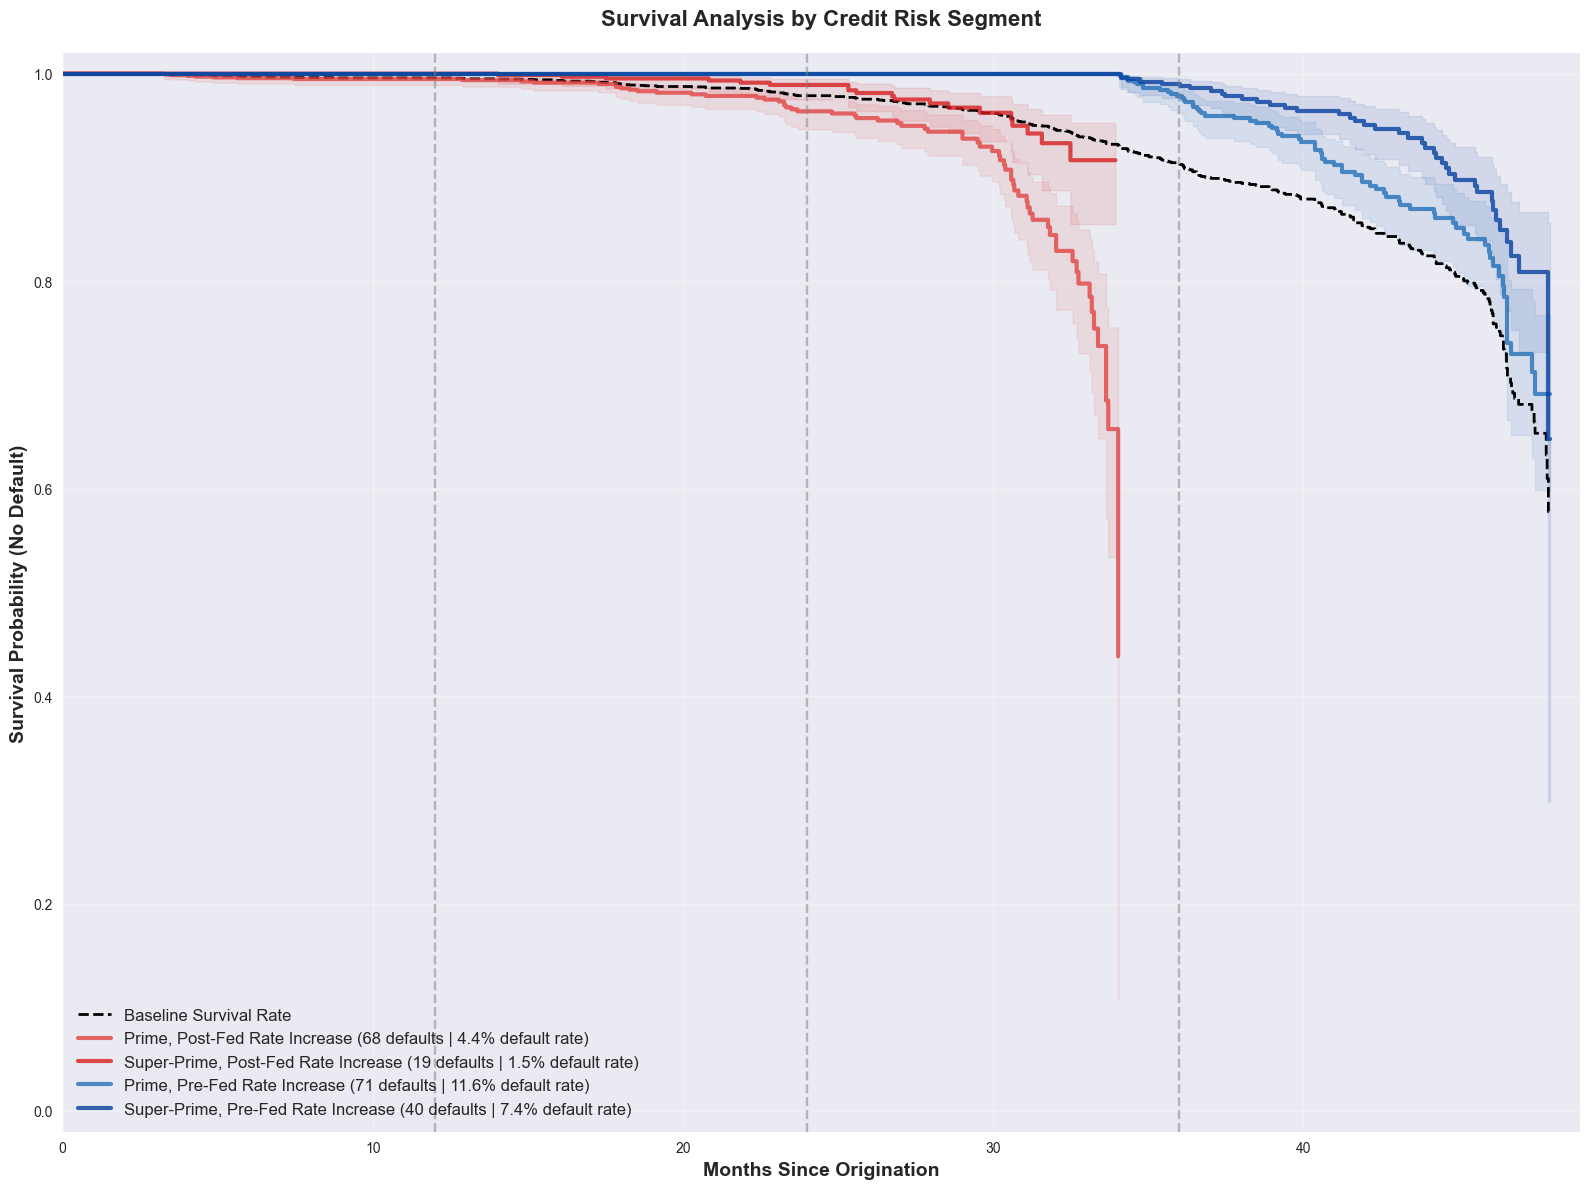

In [52]:
fig, risk_segment_col, default_rate_col, median_time_to_default_col, survival_12mo_col, survival_24mo_col, survival_36mo_col = create_combined_survival_analysis(survival_data, rate_period, score_tier, colors, baseline=True)

In [53]:
risk_segment_col, default_rate_col, median_time_to_default_col, survival_12mo_col, survival_24mo_col, survival_36mo_col

(['Prime, Post-Fed Rate Increase',
  'Super-Prime, Post-Fed Rate Increase',
  'Prime, Pre-Fed Rate Increase',
  'Super-Prime, Pre-Fed Rate Increase'],
 [4.4, 1.5, 11.6, 7.4],
 [16.69, 15.95, 41.045, 41.52],
 [99.5, 100.0, 100.0, 100.0],
 [96.4, 98.9, 100.0, 100.0],
 [43.8, 91.7, 97.9, 99.0])